## Download and Read Dataset
Using `PygGraphPropPredDataset` class to download the dataset

Graph: The ogbg-molhiv and ogbg-molpcba datasets are two molecular property prediction datasets of different sizes: ogbg-molhiv (small) and ogbg-molpcba (medium). They are adopted from the MoleculeNet [1], and are among the largest of the MoleculeNet datasets. All the molecules are pre-processed using RDKit [2]. Each graph represents a molecule, where nodes are atoms, and edges are chemical bonds. Input node features are 9-dimensional, containing atomic number and chirality, as well as other additional atom features such as formal charge and whether the atom is in the ring or not. The full description of the features is provided in code. The script to convert the SMILES string [3] to the above graph object can be found here. Note that the script requires RDkit to be installed. The script can be used to pre-process external molecule datasets so that those datasets share the same input feature space as the OGB molecule datasets. This is particularly useful for pre-training graph models, which has great potential to significantly increase generalization performance on the (downstream) OGB datasets [4].

Prediction task: The task is to predict the target molecular properties as accurately as possible, where the molecular properties are cast as binary labels, e.g, whether a molecule inhibits HIV virus replication or not. Note that some datasets (e.g., ogbg-molpcba) can have multiple tasks, and can contain nan that indicates the corresponding label is not assigned to the molecule. For evaluation metric, we closely follow [1]. Specifically, for ogbg-molhiv, we use ROC-AUC for evaluation. For ogbg-molpcba, as the class balance is extremely skewed (only 1.4% of data is positive) and the dataset contains multiple classification tasks, we use the Average Precision (AP) averaged over the tasks as the evaluation metric.

Dataset splitting: We adopt the scaffold splitting procedure that splits the molecules based on their two-dimensional structural frameworks. The scaffold splitting attempts to separate structurally different molecules into different subsets, which provides a more realistic estimate of model performance in prospective experimental settings [1].

In [179]:
import os
import torch

os.environ["TORCH"] = torch.__version__
print(torch.__version__)

# !pip install ogb
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# !git clone https://github.com/snap-stanford/ogb.git

2.1.0+cu118


In [180]:
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

# Download and process data at './dataset/ogbg_molhiv/'
dataset = PygGraphPropPredDataset(name="ogbg-molhiv")

## Check Dataset Info
Check basic dataset information using `PyG`

In [181]:
print(f"len(dataset): {len(dataset)} <- number of graphs")
print(f"dataset.num_classes: {dataset.num_classes} <- number of labels for classes")
print(
    f"dataset.num_node_features: {dataset.num_node_features} <- number of features for each node of graphs"
)
print(
    f"dataset.num_edge_features: {dataset.num_edge_features} <- number of features for each edge of graphs"
)

len(dataset): 41127 <- number of graphs
dataset.num_classes: 2 <- number of labels for classes
dataset.num_node_features: 9 <- number of features for each node of graphs
dataset.num_edge_features: 3 <- number of features for each edge of graphs


## Check Graph Info
Check basic graph information using `PyG`

In [182]:
graph_number = 0
graph: Data = dataset[graph_number]
print(graph)
print("\n")
print(f"graph.num_nodes: {graph.num_nodes}")
print(f"graph.num_edges: {graph.num_edges}")
print(f"graph.has_isolated_nodes: {graph.has_isolated_nodes()}")
print(f"graph.has_self_loops: {graph.has_self_loops()}")
print(f"graph.is_directed: {graph.is_directed()}")
print("\n")
print("x:\t\t", graph.x.shape)
print(graph.x)
print("\n")
print("y:\t\t", graph.y.shape)
print(graph.y)
print("\n")
print("edge_attr:\t\t", graph.edge_attr.shape)
print(graph.edge_attr)
print("\n")
print("edge_index:\t\t", graph.edge_index.shape)
print(graph.edge_index)
print("\n")

Data(edge_index=[2, 40], edge_attr=[40, 3], x=[19, 9], y=[1, 1], num_nodes=19)


graph.num_nodes: 19
graph.num_edges: 40
graph.has_isolated_nodes: False
graph.has_self_loops: False
graph.is_directed: False


x:		 torch.Size([19, 9])
tensor([[ 5,  0,  4,  5,  3,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  0],
        [ 5,  0,  3,  5,  0,  0,  1,  0,  1],
        [ 7,  0,  2,  6,  0,  0,  1,  0,  1],
        [28,  0,  4,  2,  0,  0,  5,  0,  1],
        [ 7,  0,  2,  6,  0,  0,  1,  0,  1],
        [ 5,  0,  3,  5,  0,  0,  1,  0,  1],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  3,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  1],
        [ 7,  0,  2,  6,  0,  0,  1,  0,  1],
        [ 5,  0,  3,  5,  0,  0,  1,  0,  1],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  3,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  1],
        [ 5,  0,  3,  5,  0,  0,  1,  0,  1],
        [ 5,  0,  4,  5,  2,  0

## Convert pyg graphs to networkx graphs
Helper function to convert pyg graph to networkx

In [183]:
def pyg_to_networkx(pyg_graph: Data) -> nx.Graph:
    """Convert pyg graph to networkx graph

    Parameters
    ----------
    pyg_graph: torch_geometric.data.Data
        The pyg graph

    Returns
    ----------
    networkx_graph: nx.Graph
        The networkx graph
    """
    return to_networkx(
        pyg_graph,
        node_attrs=["x"],
        edge_attrs=["edge_attr"],
        graph_attrs=["y"],
        to_undirected=True,
    )

## Get attributes of networkx graphs
The generated networkx graph from pyg graph have some attributes for each nodes, edges and whole graph. Let's print them.

In [184]:
graph: Data = dataset[0]
networkx_graph = pyg_to_networkx(graph)
print(f"graph type: {type(networkx_graph)}")
print(f"graph node attributes: {networkx_graph.nodes(data=True)}")
print(f"graph attributes: {networkx_graph.graph['y'][0][0]}")

graph type: <class 'networkx.classes.graph.Graph'>
graph node attributes: [(0, {'x': [5, 0, 4, 5, 3, 0, 2, 0, 0]}), (1, {'x': [5, 0, 4, 5, 2, 0, 2, 0, 0]}), (2, {'x': [5, 0, 3, 5, 0, 0, 1, 0, 1]}), (3, {'x': [7, 0, 2, 6, 0, 0, 1, 0, 1]}), (4, {'x': [28, 0, 4, 2, 0, 0, 5, 0, 1]}), (5, {'x': [7, 0, 2, 6, 0, 0, 1, 0, 1]}), (6, {'x': [5, 0, 3, 5, 0, 0, 1, 0, 1]}), (7, {'x': [5, 0, 4, 5, 2, 0, 2, 0, 0]}), (8, {'x': [5, 0, 4, 5, 3, 0, 2, 0, 0]}), (9, {'x': [5, 0, 4, 5, 2, 0, 2, 0, 1]}), (10, {'x': [7, 0, 2, 6, 0, 0, 1, 0, 1]}), (11, {'x': [5, 0, 3, 5, 0, 0, 1, 0, 1]}), (12, {'x': [5, 0, 4, 5, 2, 0, 2, 0, 0]}), (13, {'x': [5, 0, 4, 5, 3, 0, 2, 0, 0]}), (14, {'x': [5, 0, 4, 5, 2, 0, 2, 0, 1]}), (15, {'x': [5, 0, 3, 5, 0, 0, 1, 0, 1]}), (16, {'x': [5, 0, 4, 5, 2, 0, 2, 0, 0]}), (17, {'x': [5, 0, 4, 5, 3, 0, 2, 0, 0]}), (18, {'x': [7, 0, 2, 6, 0, 0, 1, 0, 1]})]
graph attributes: 0


### Get n Graph for binary group labels of graphs
Helper function to get **n** graphs of labels **0** and **n** graphs or label **1**

In [185]:
def get_n_from_each_group(
    n: int, dataset: PygGraphPropPredDataset
) -> tuple[list[nx.Graph], list[nx.Graph]]:
    """Get n graphs of each binary grouped graphs from pyg dataset of graphs

    Parameters
    ----------
    dataset: PygGraphPropPredDataset
        The pyg graph dataset
    n: int
        The number of graph to be return in each binary group 0 and 1

    Returns
    ----------
    (hiv_positive_graphs, hiv_negative_graphs): tuple[list[nx.Graph], list[nx.Graph]]
        The tuple of positive hiv graphs and negative hiv graphs
    """
    enough_hiv_positive_graphs = n
    enough_hiv_negative_graphs = n
    hiv_positive_graphs: list[nx.Graph] = []
    hiv_negative_graphs: list[nx.Graph] = []
    for graph in dataset:
        if enough_hiv_negative_graphs == 0 and enough_hiv_positive_graphs == 0:
            break
        if (graph.y[0][0] == 0) and enough_hiv_negative_graphs > 0:
            networkx_graph = pyg_to_networkx(graph)
            hiv_negative_graphs.append(networkx_graph)
            enough_hiv_negative_graphs = enough_hiv_negative_graphs - 1
        if (graph.y[0][0] == 1) and enough_hiv_positive_graphs > 0:
            networkx_graph = pyg_to_networkx(graph)
            hiv_positive_graphs.append(networkx_graph)
            enough_hiv_positive_graphs = enough_hiv_positive_graphs - 1

    return (hiv_positive_graphs, hiv_negative_graphs)

In [186]:
(hiv_positive_graphs, hiv_negative_graphs) = get_n_from_each_group(n=5, dataset=dataset)

In [187]:
print(len(hiv_positive_graphs))
print(len(hiv_negative_graphs))

5
5


### Plot some graphs
Plot five **HIV Positive** and five **HIV Negative** graphs in single plot

Helper function to plot networkx graph

In [188]:
def plot_networkx_graph(
    networkX_graph: nx.Graph, graph_number: int, labels: dict = {}
) -> None:
    """Plot one of ten networkx graphs in 2*5 subplot figure
    Parameters
    ----------
    networkX_graph: nx.Graph
        The networkx graph
    graph_number: int
        The index number of graph to be inserted in figure as subplot
    label: dict
    Returns
    ----------
    None
    """
    node_color = "lightsteelblue"
    hiv = ""
    if networkX_graph.graph["y"][0][0] != 0:
        node_color = "lightcoral"
        hiv = "HIV "

    plt.subplot(2, 5, graph_number + 1, frameon=False)
    plt.title(f"{hiv}Graph # {str(graph_number + 1)}")
    plt.axis("off")

    options = {
        "node_color": node_color,
        "node_size": 1500,
        "font_size": 20,
        "width": 5,
    }


    if labels != {}:
        options["labels"] = labels

    nx.draw_kamada_kawai(networkX_graph, with_labels=True, **options)

    return None

#### Main Graphs

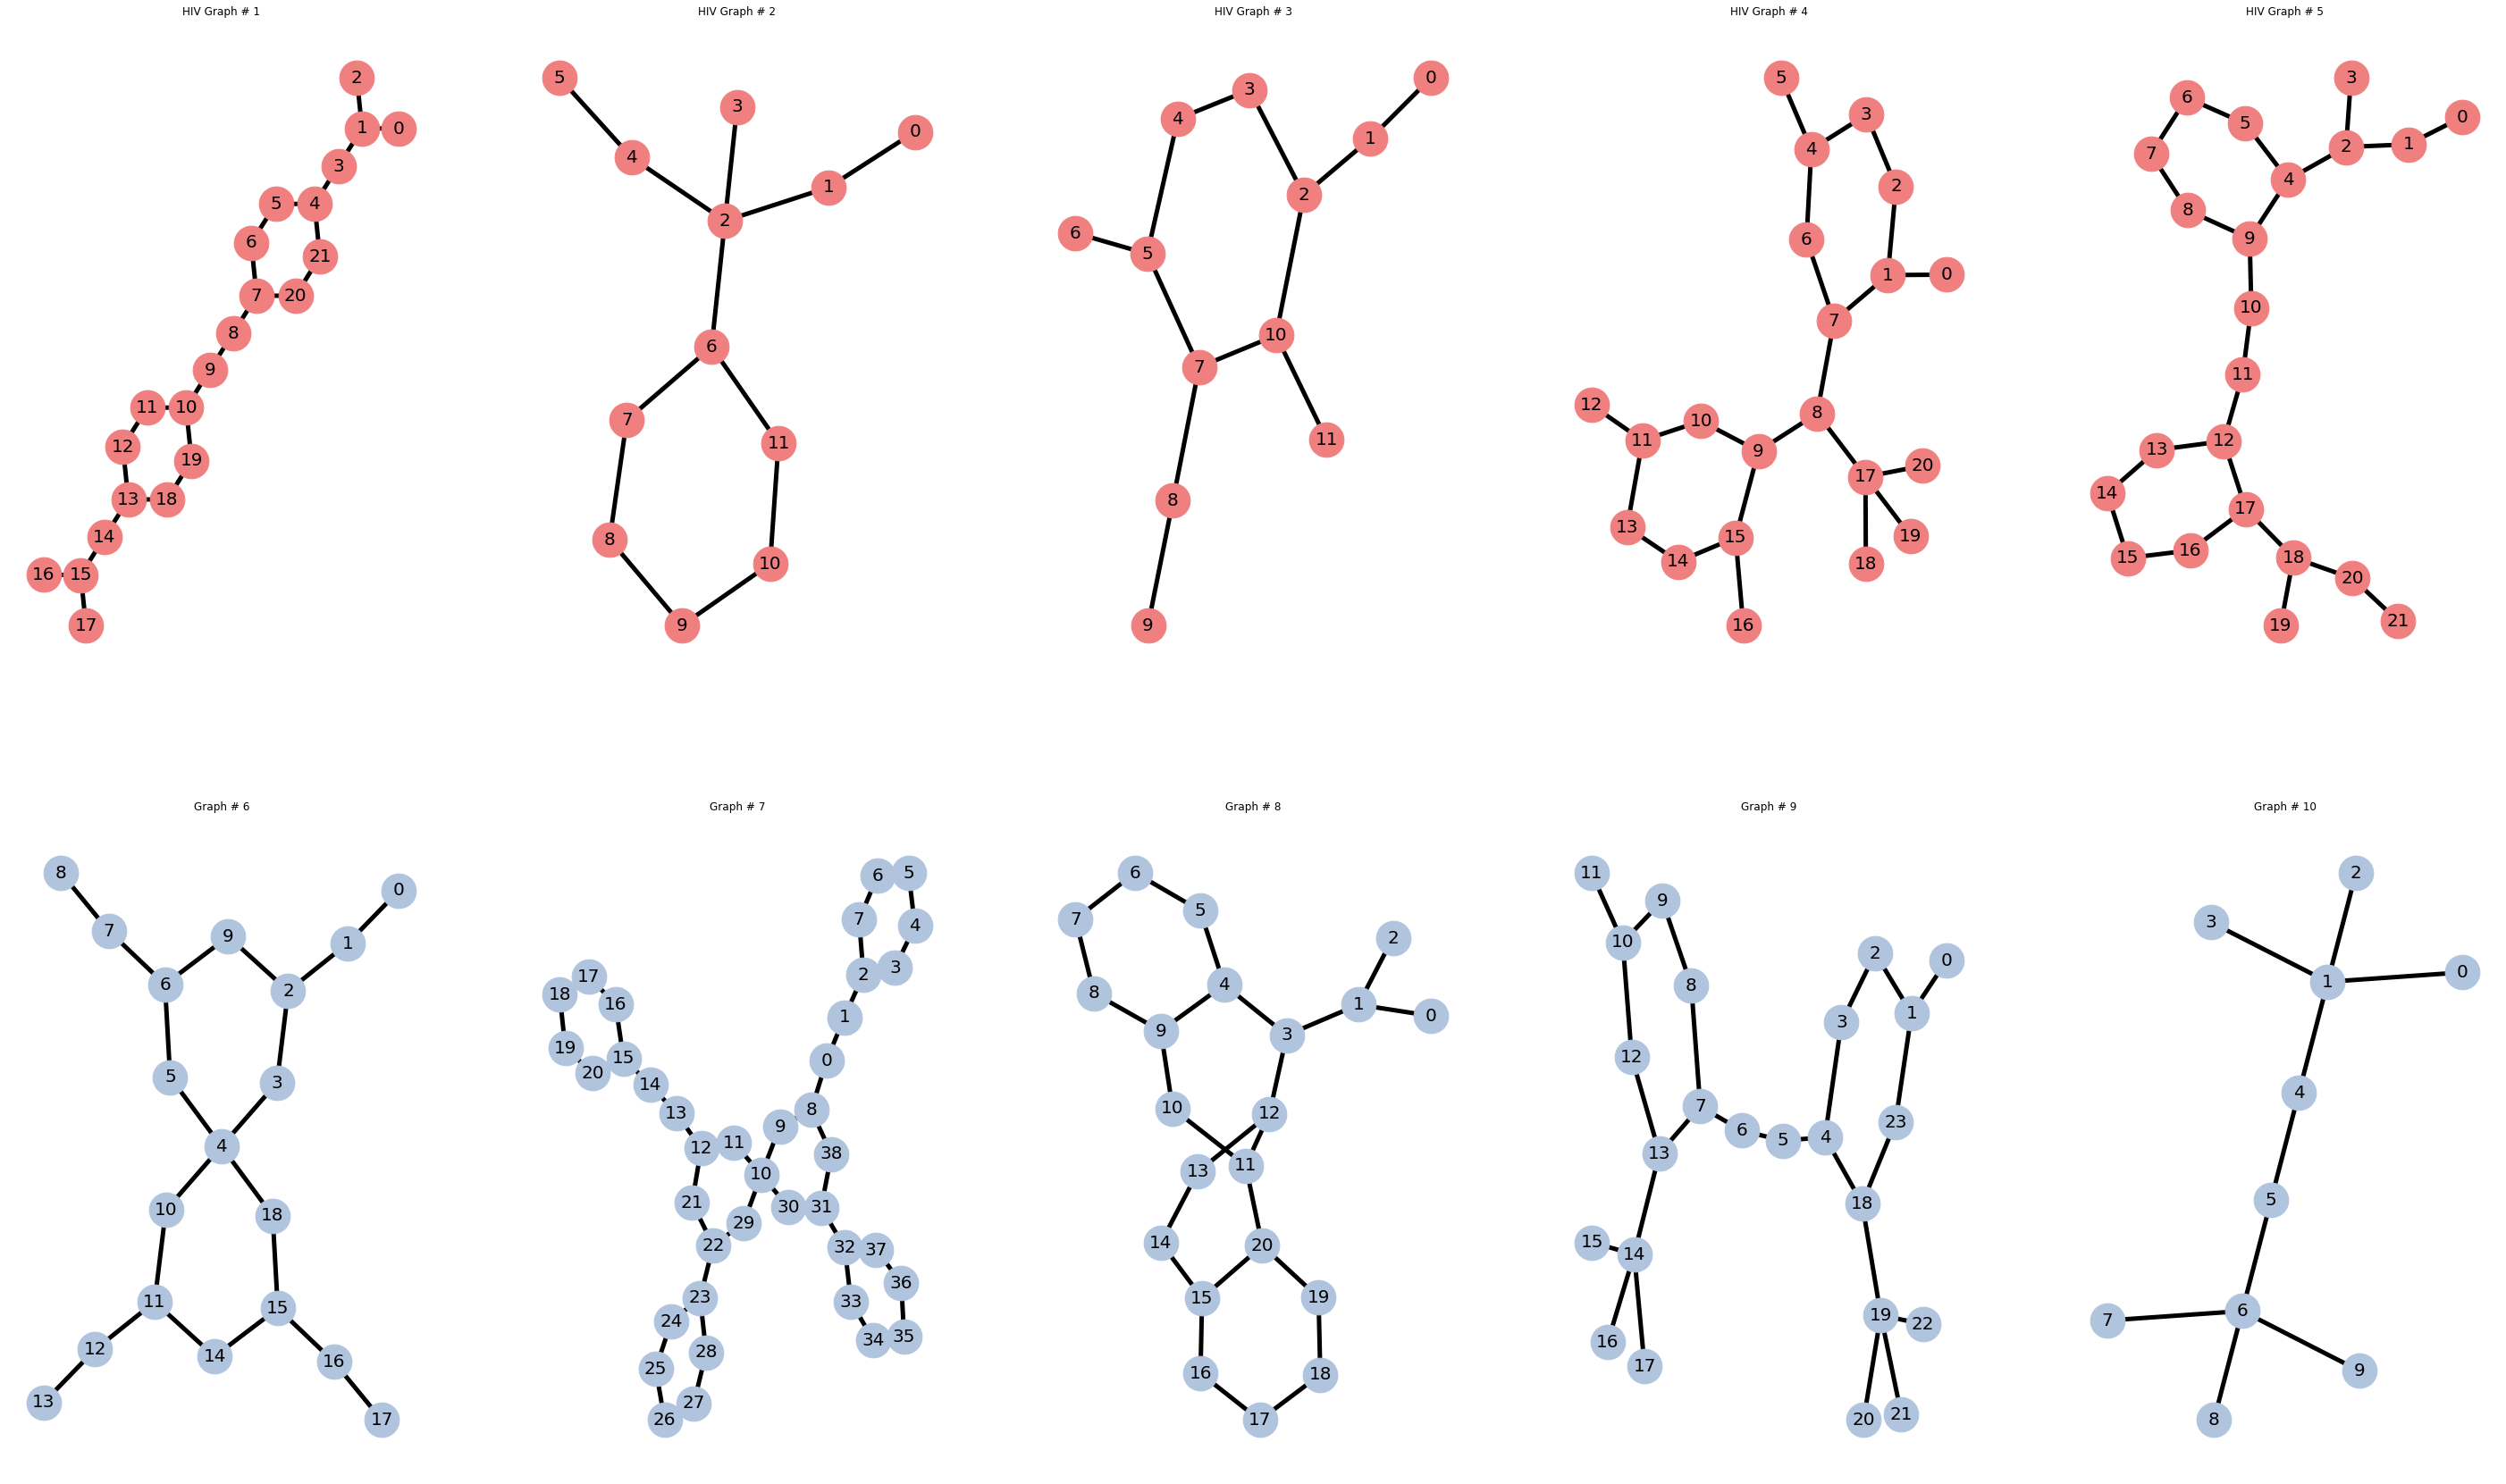

In [189]:
plt.figure(figsize=(50, 30))
for graph_number, networkx_graph in enumerate(
    hiv_positive_graphs + hiv_negative_graphs
):
    plot_networkx_graph(networkx_graph, graph_number)
plt.show()

#### Node Degree

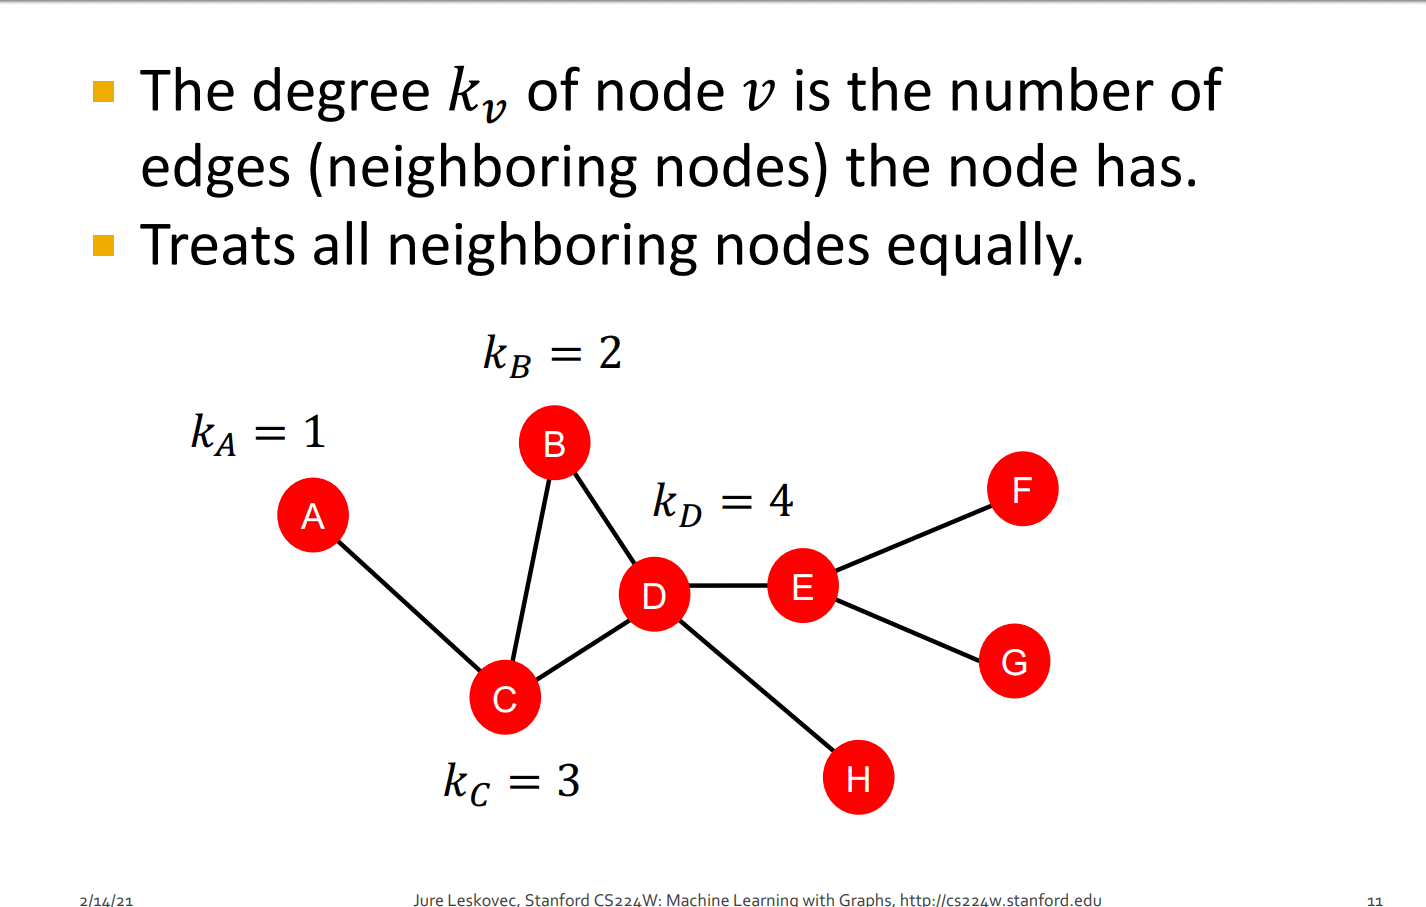

In [190]:
def DEachGraph(Graphs: list[nx.Graph]) -> list:
    degree_list = []
    for graph in Graphs:
        degree = dict(nx.degree(graph))
        degree_list.append(degree)
    return degree_list

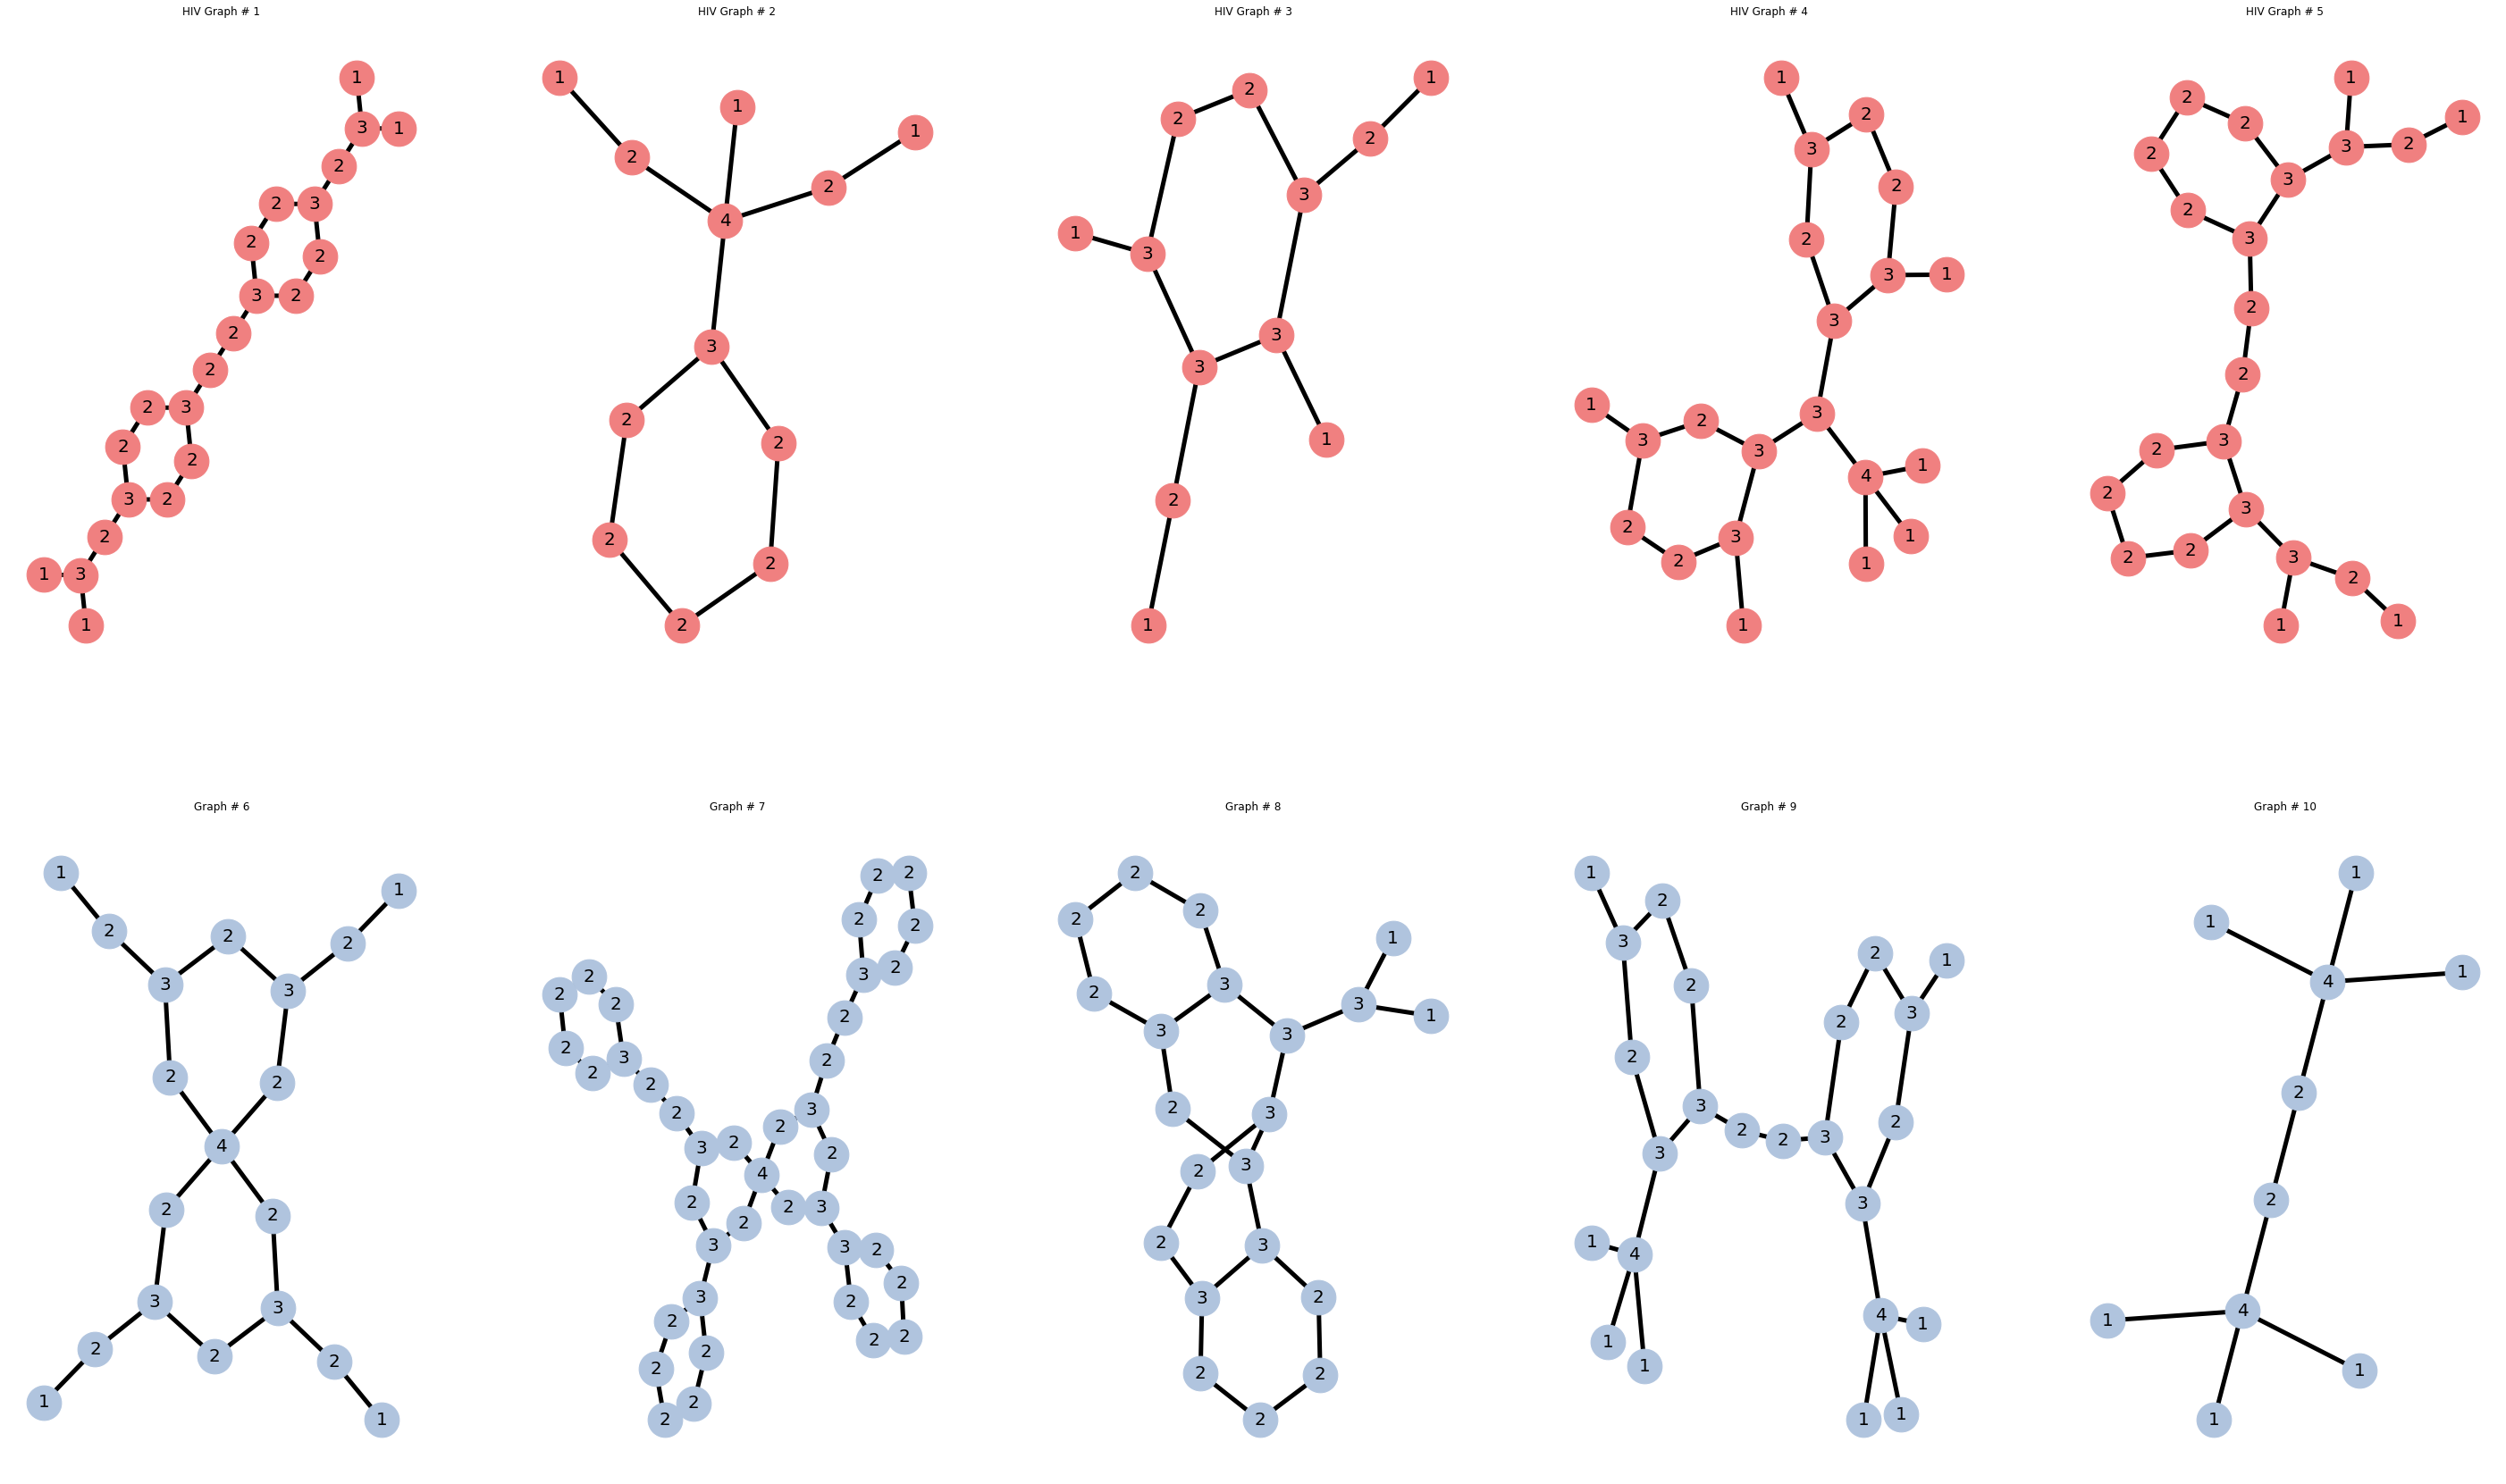

In [191]:
plt.figure(figsize=(50, 30))
for graph_number, networkx_graph in enumerate(
    hiv_positive_graphs + hiv_negative_graphs
):
    if graph_number <= 4:
        plot_networkx_graph(
            networkx_graph, graph_number, DEachGraph(hiv_positive_graphs)[graph_number]
        )
    else:
        plot_networkx_graph(
            networkx_graph,
            graph_number,
            DEachGraph(hiv_negative_graphs)[graph_number - 5],
        )
plt.show()

#### Eigenvector centrality

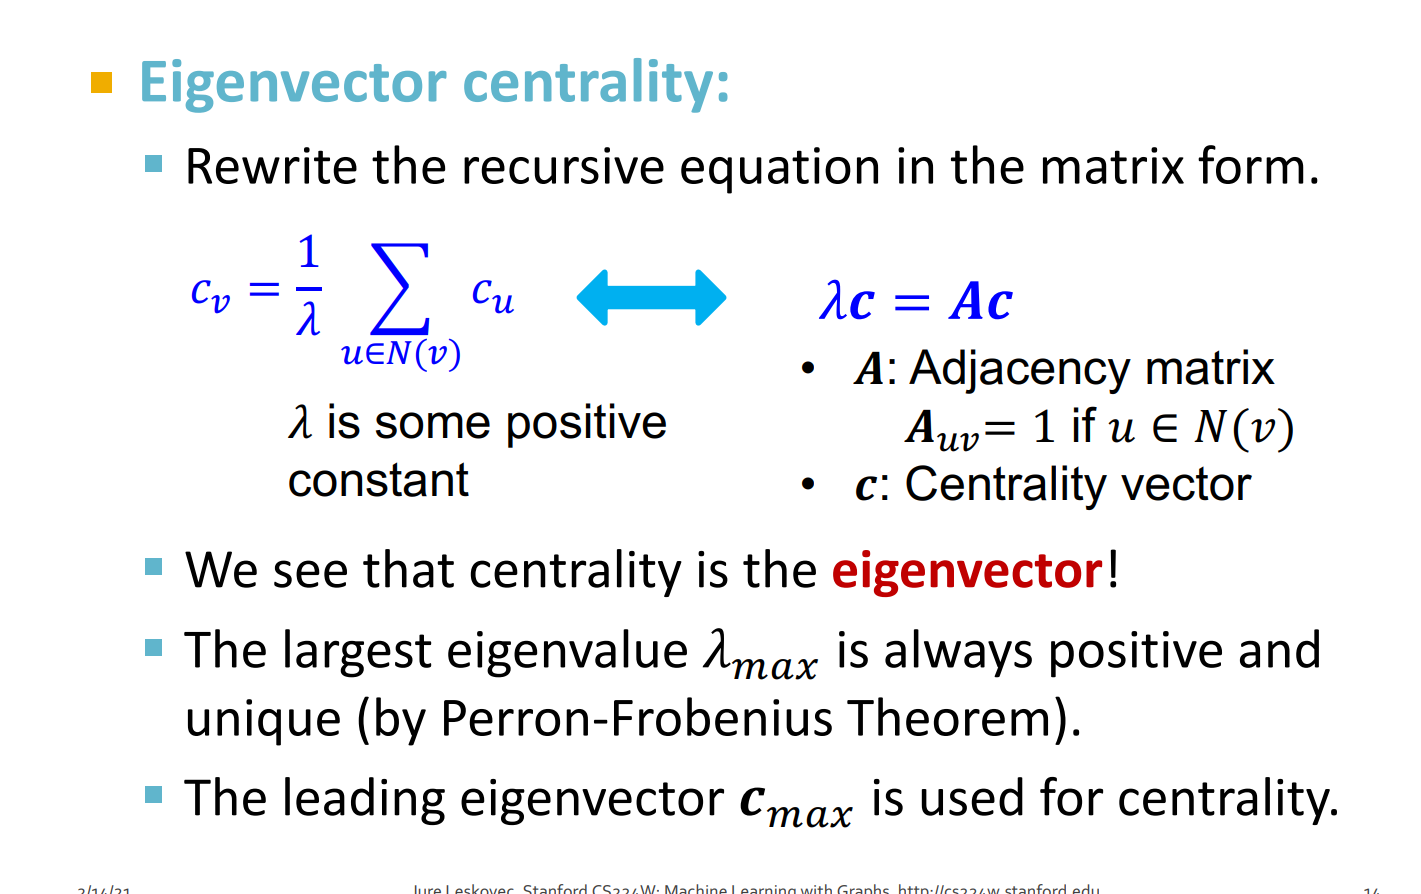

In [192]:
def ECEachGraph(Graphs: list[nx.Graph]) -> list:
    ec_list = []
    for graph in Graphs:
        eigenvector_centrality = nx.eigenvector_centrality(graph)
        ec_list.append(
            {key: round(value, 2) for key, value in eigenvector_centrality.items()}
        )
    return ec_list

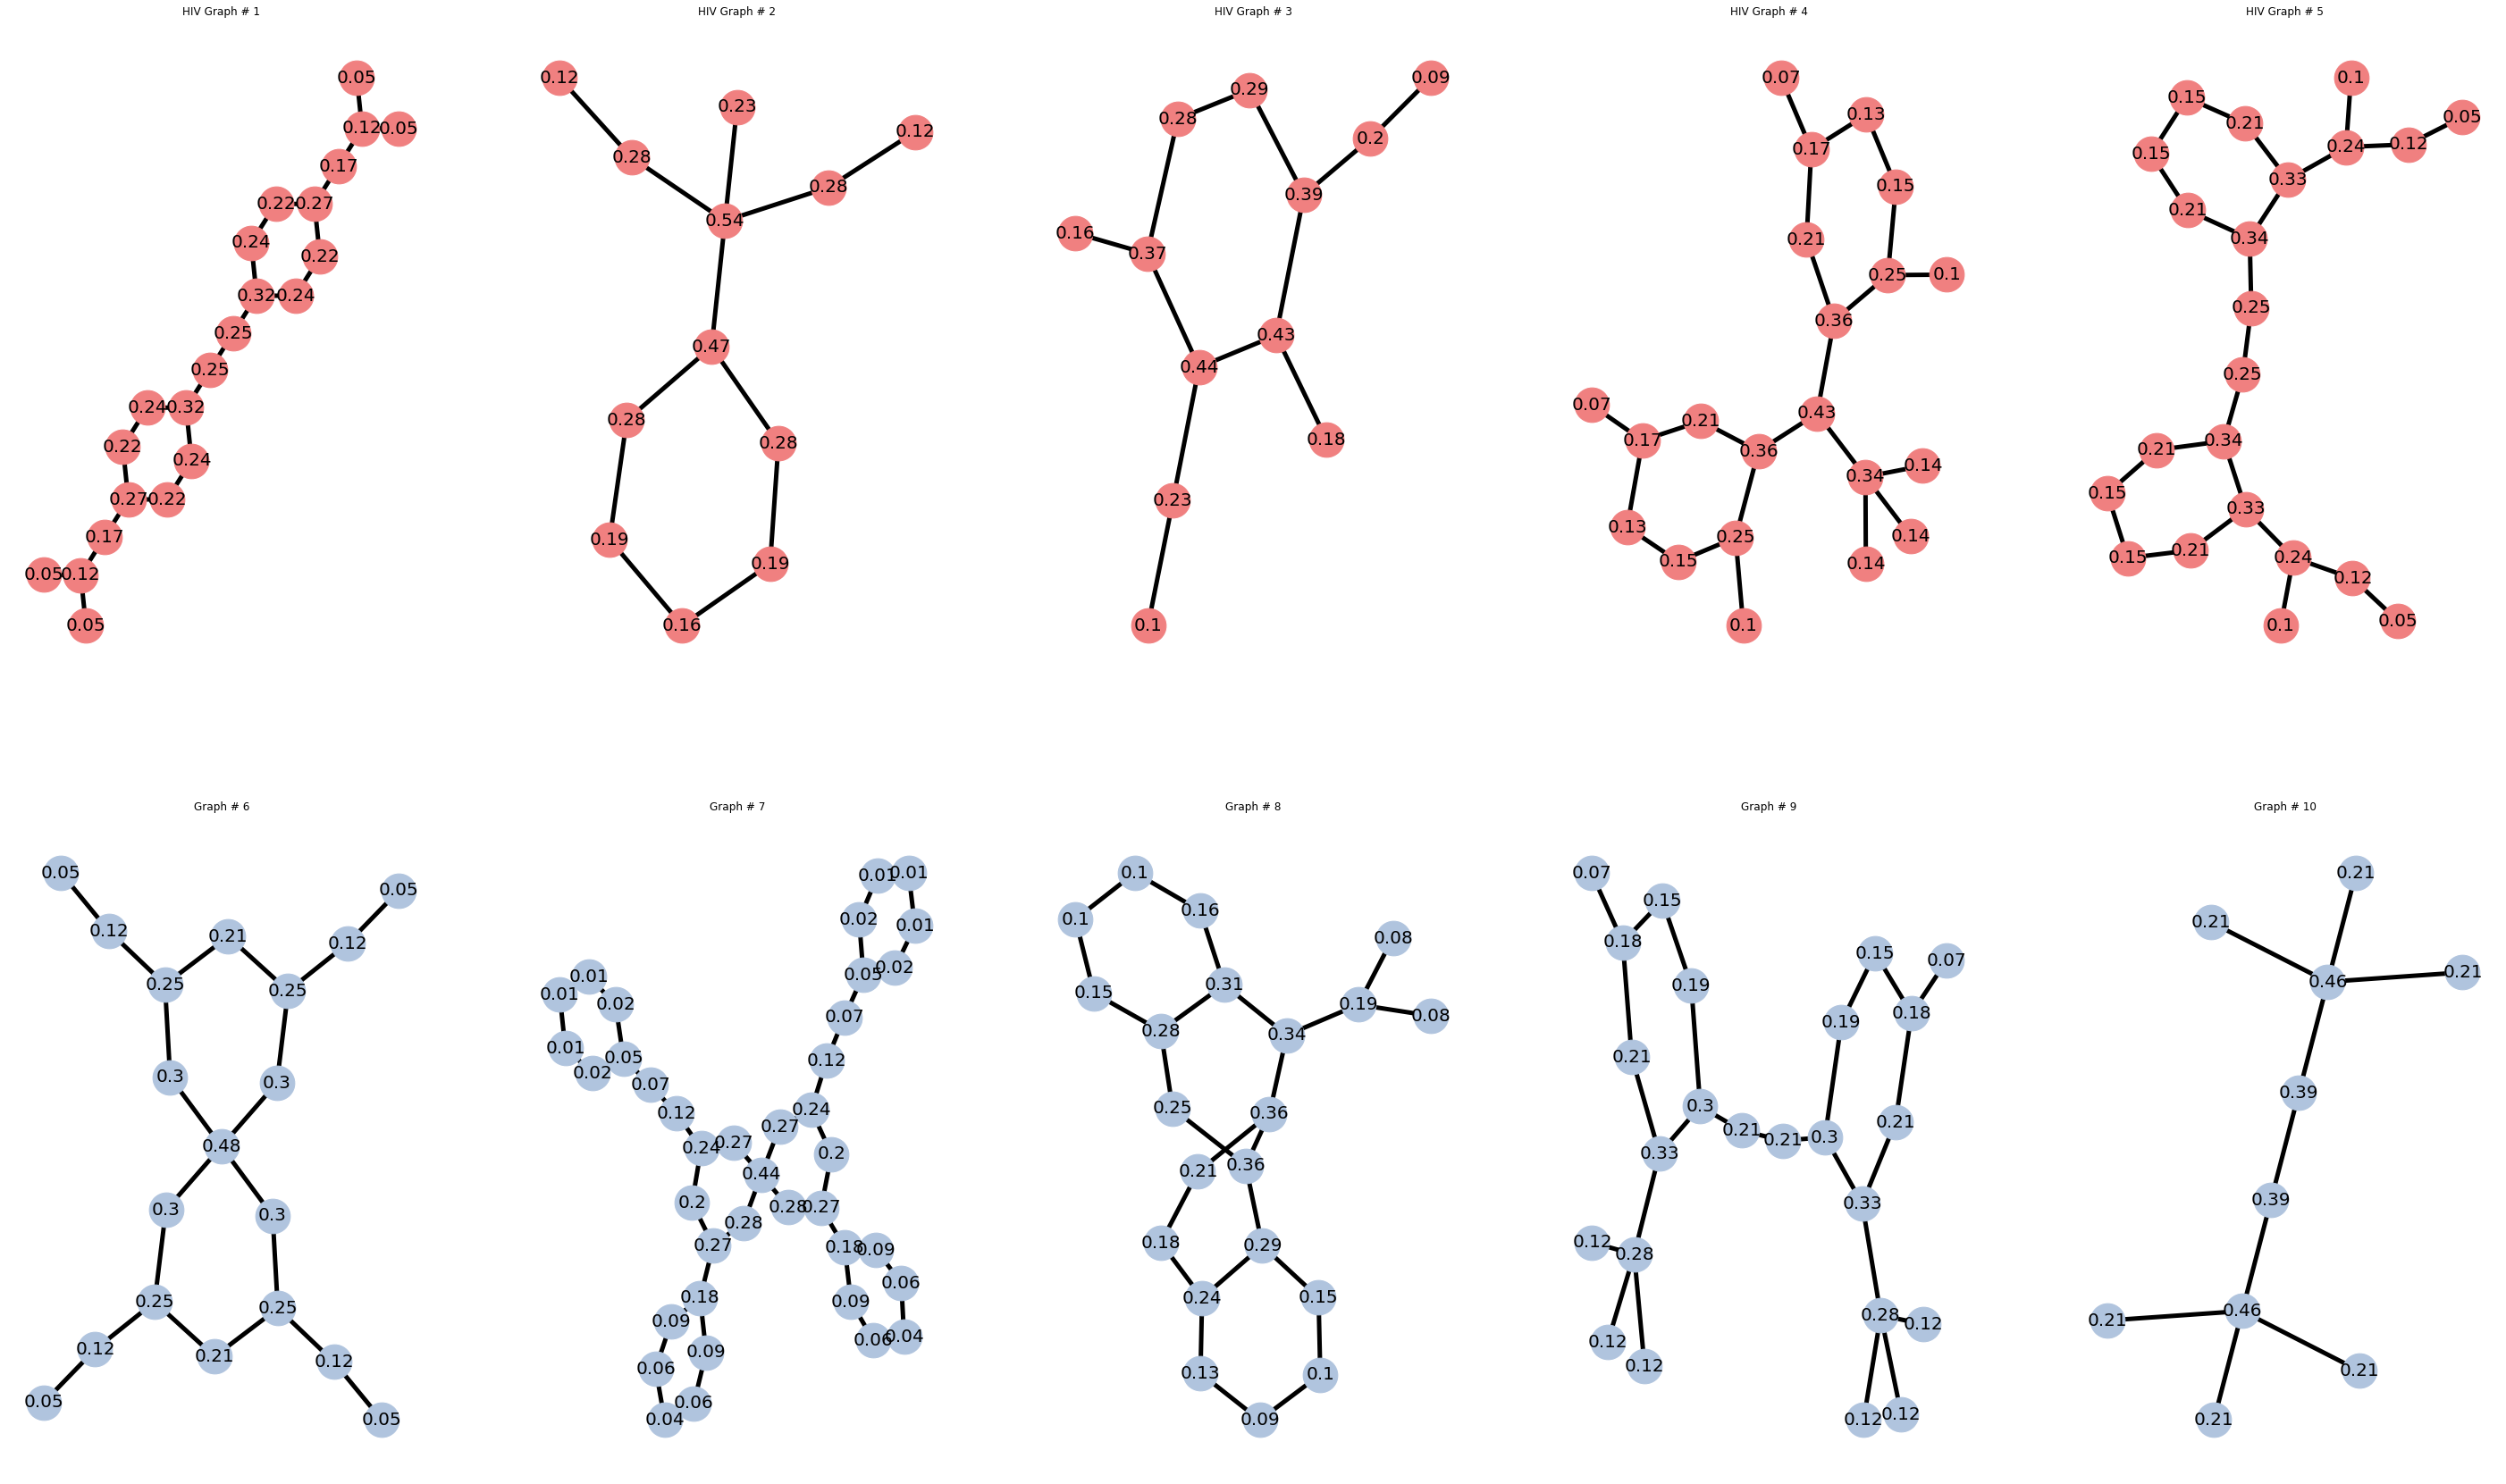

In [193]:
plt.figure(figsize=(50, 30))
for graph_number, networkx_graph in enumerate(
    hiv_positive_graphs + hiv_negative_graphs
):
    if graph_number <= 4:
        plot_networkx_graph(
            networkx_graph, graph_number, ECEachGraph(hiv_positive_graphs)[graph_number]
        )
    else:
        plot_networkx_graph(
            networkx_graph,
            graph_number,
            ECEachGraph(hiv_negative_graphs)[graph_number - 5],
        )
plt.show()

#### Betweenness centrality

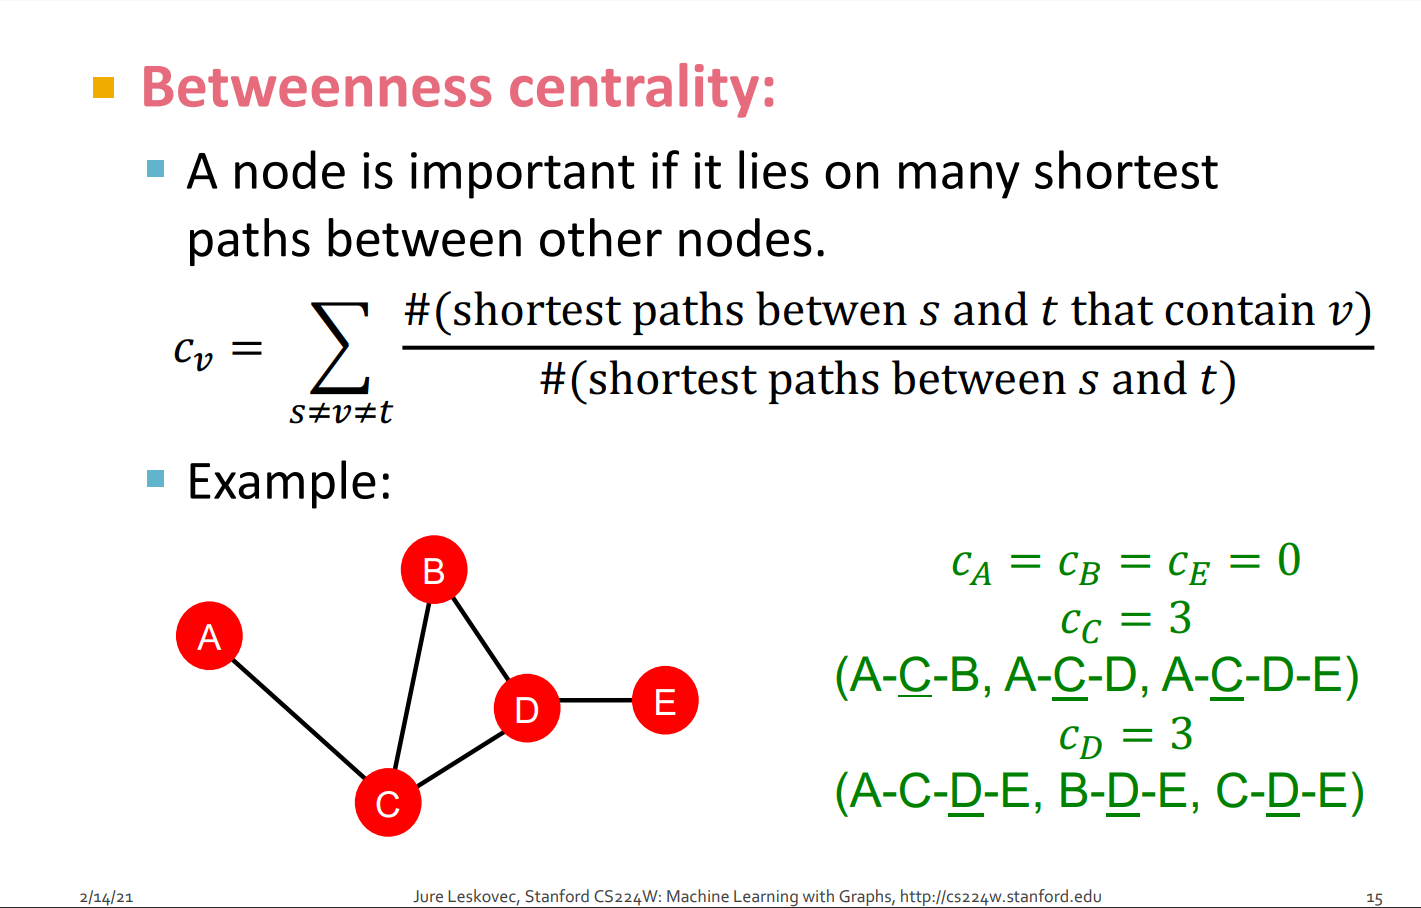

In [194]:
def BCEachGraph(Graphs: list[nx.Graph]) -> list:
    bc_list = []
    for graph in Graphs:
        betweenness_centrality = nx.betweenness_centrality(graph)
        bc_list.append(
            {key: round(value, 2) for key, value in betweenness_centrality.items()}
        )
    return bc_list

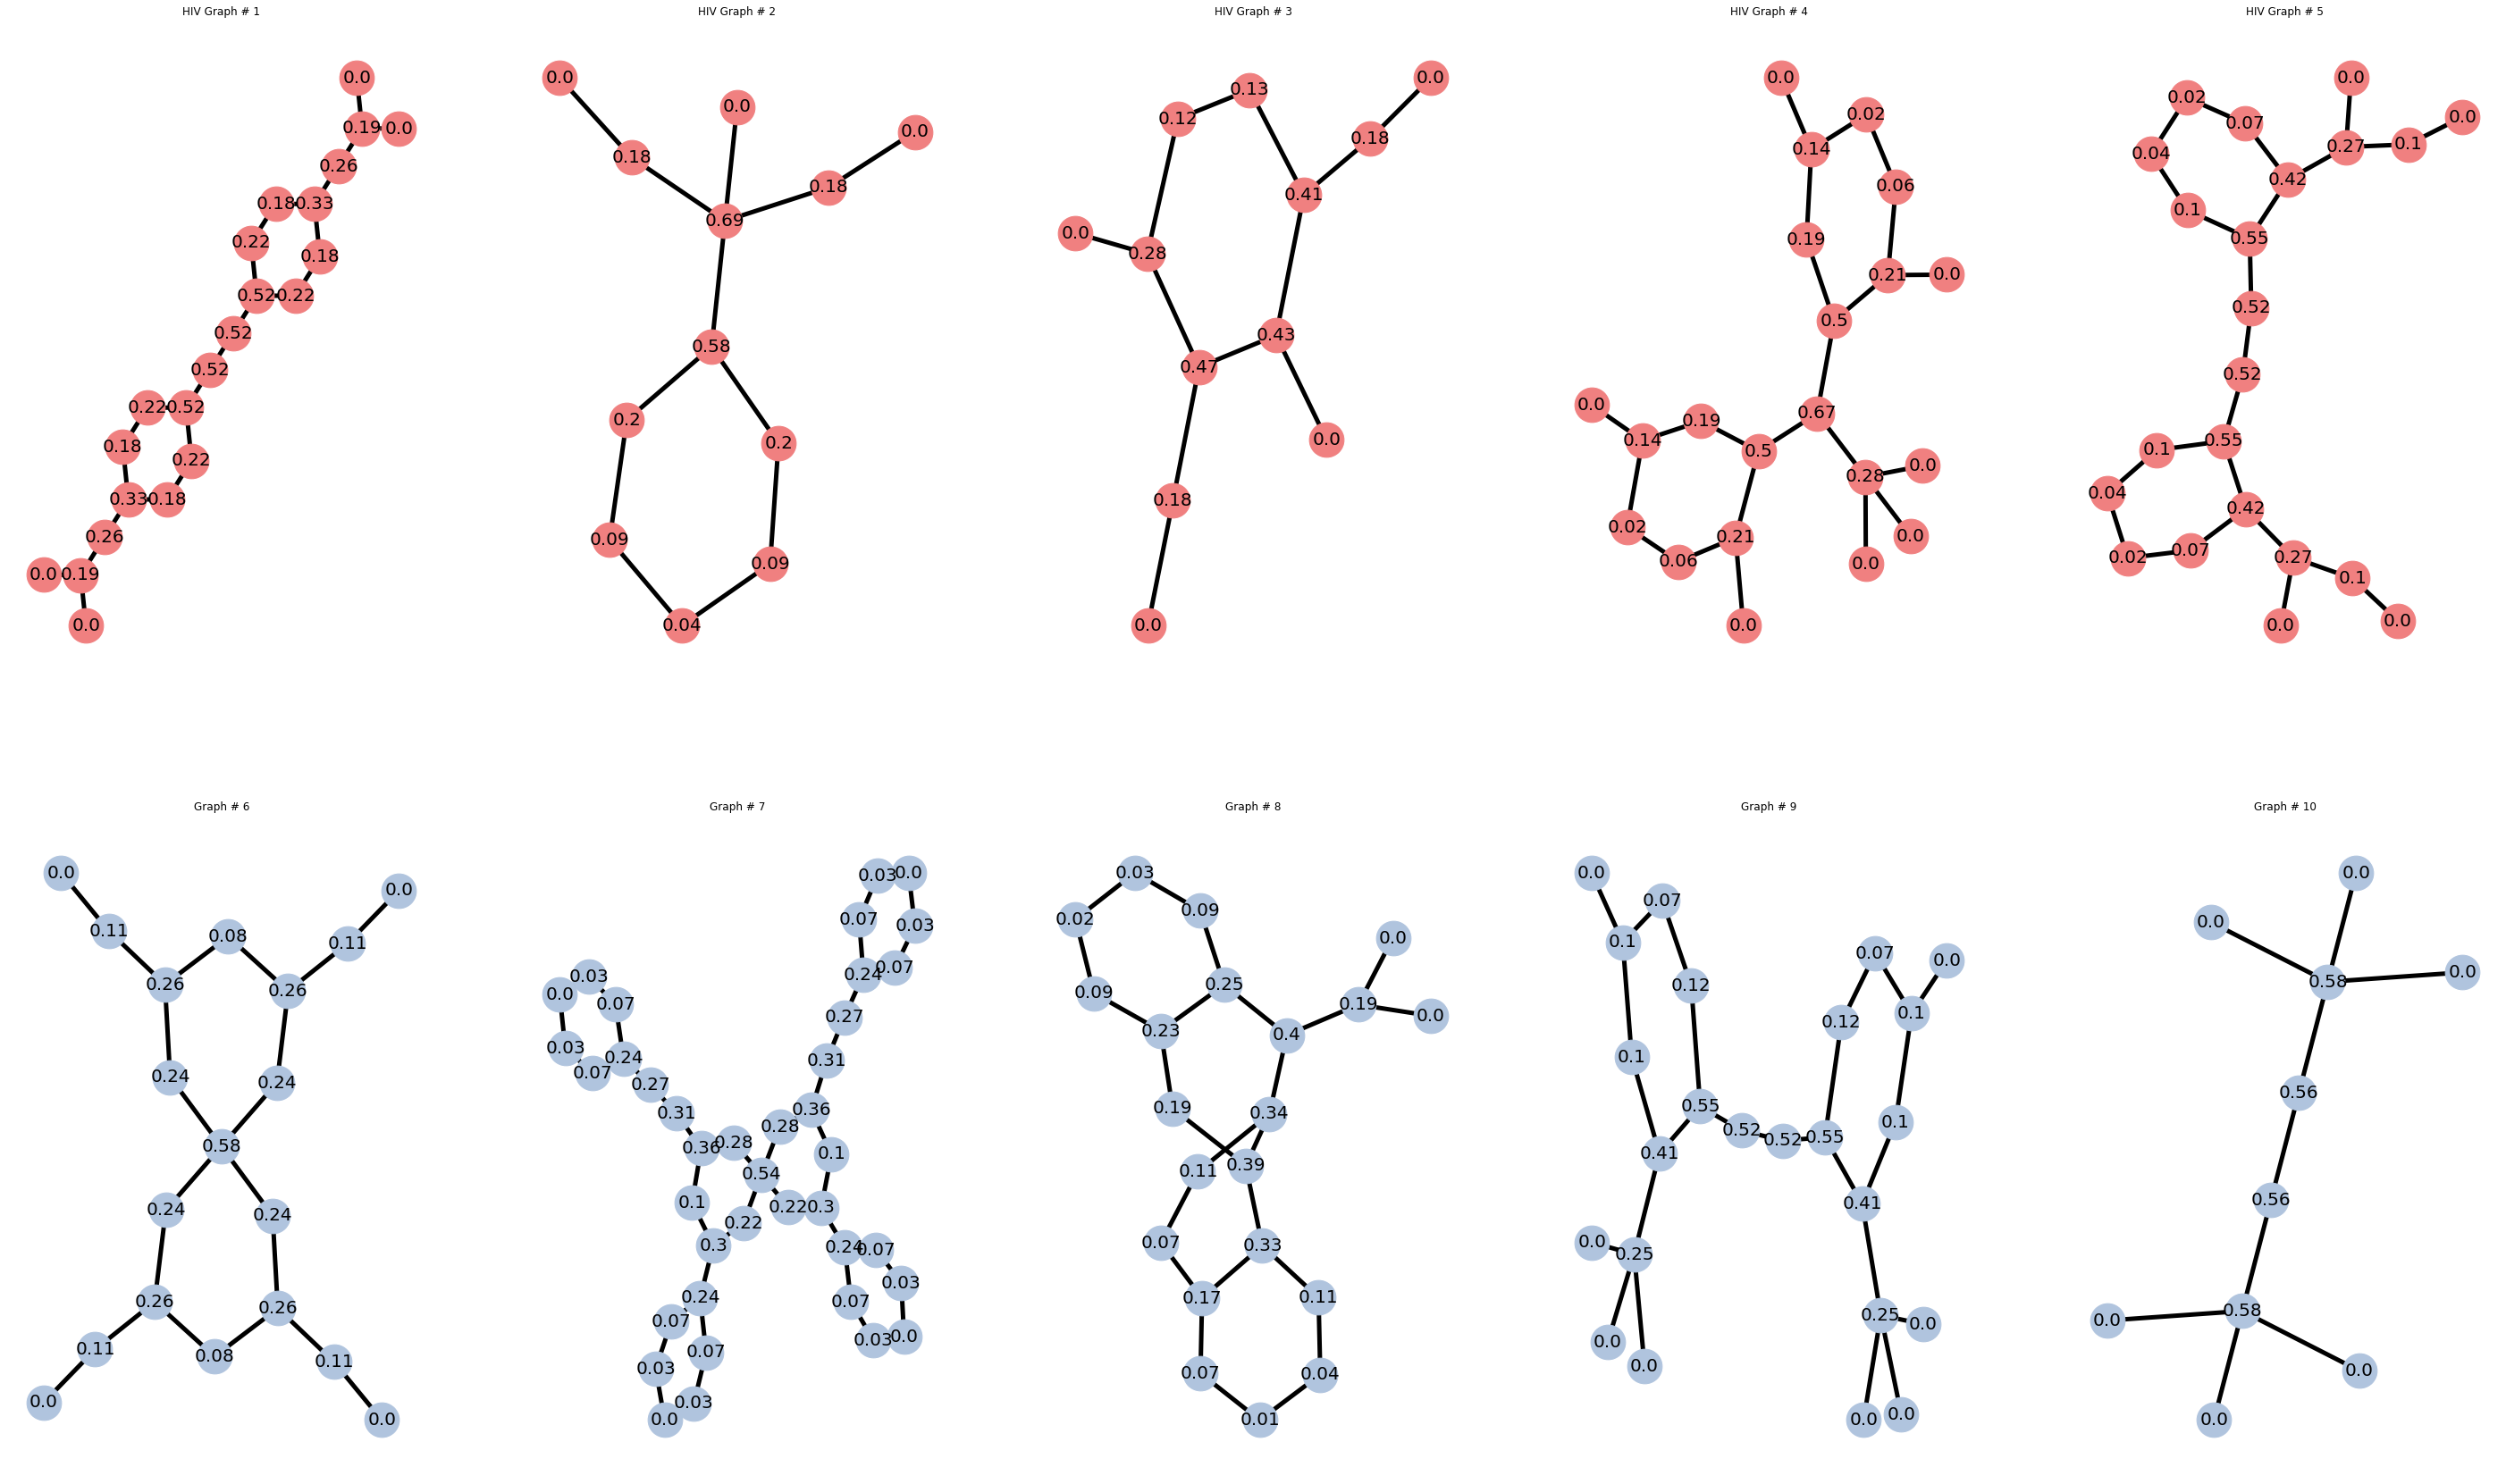

In [195]:
plt.figure(figsize=(50, 30))
for graph_number, networkx_graph in enumerate(
    hiv_positive_graphs + hiv_negative_graphs
):
    if graph_number <= 4:
        plot_networkx_graph(
            networkx_graph, graph_number, BCEachGraph(hiv_positive_graphs)[graph_number]
        )
    else:
        plot_networkx_graph(
            networkx_graph,
            graph_number,
            BCEachGraph(hiv_negative_graphs)[graph_number - 5],
        )
plt.show()

#### Closeness centrality

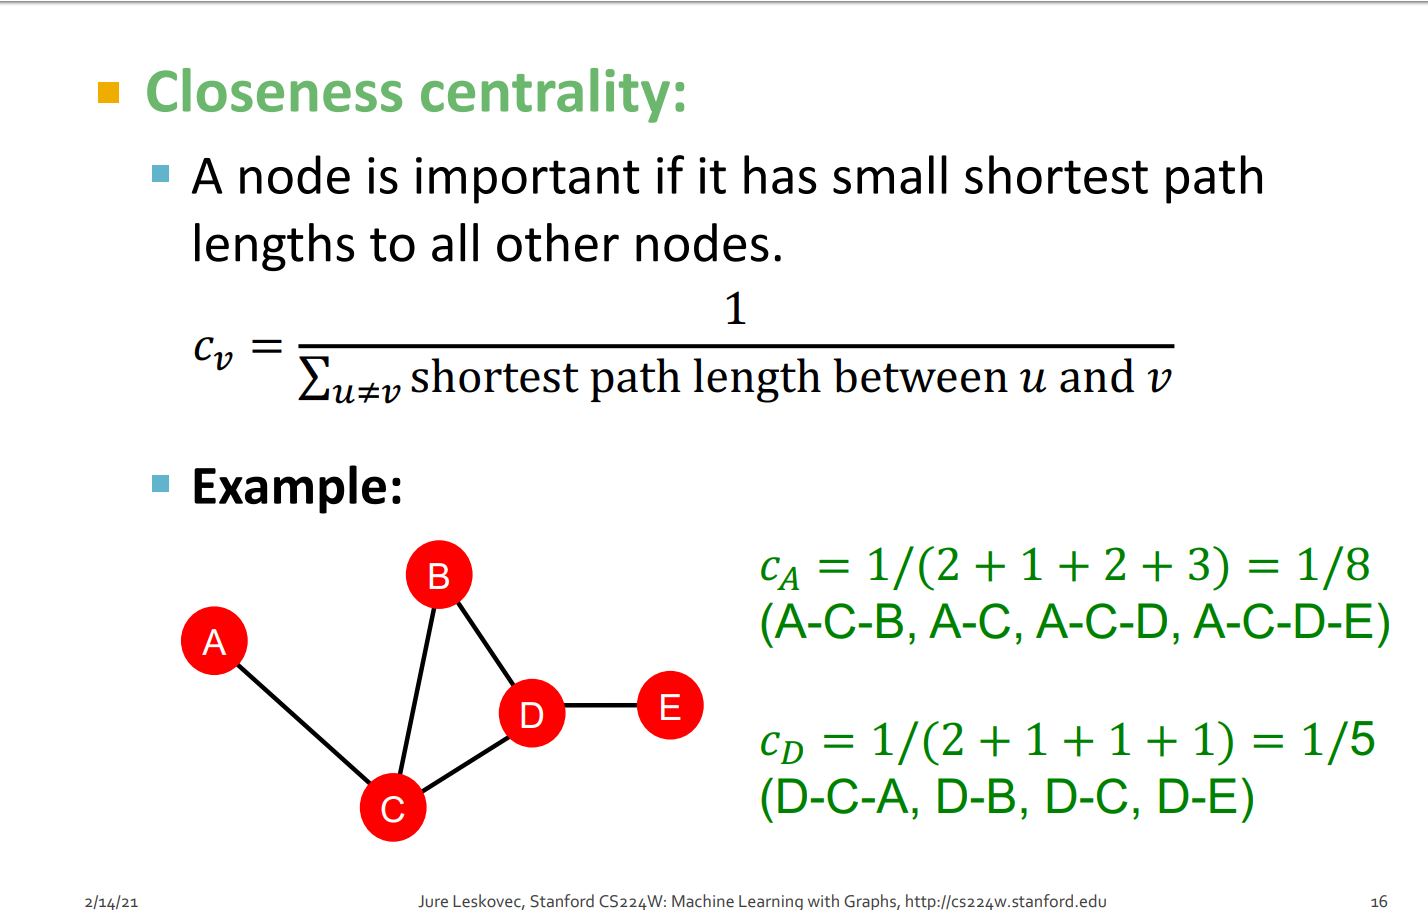

In [196]:
def ClCEachGraph(Graphs: list[nx.Graph]) -> list:
    clc_list = []
    for graph in Graphs:
        closeness_centrality = nx.closeness_centrality(graph)
        clc_list.append(
            {key: round(value, 2) for key, value in closeness_centrality.items()}
        )
    return clc_list

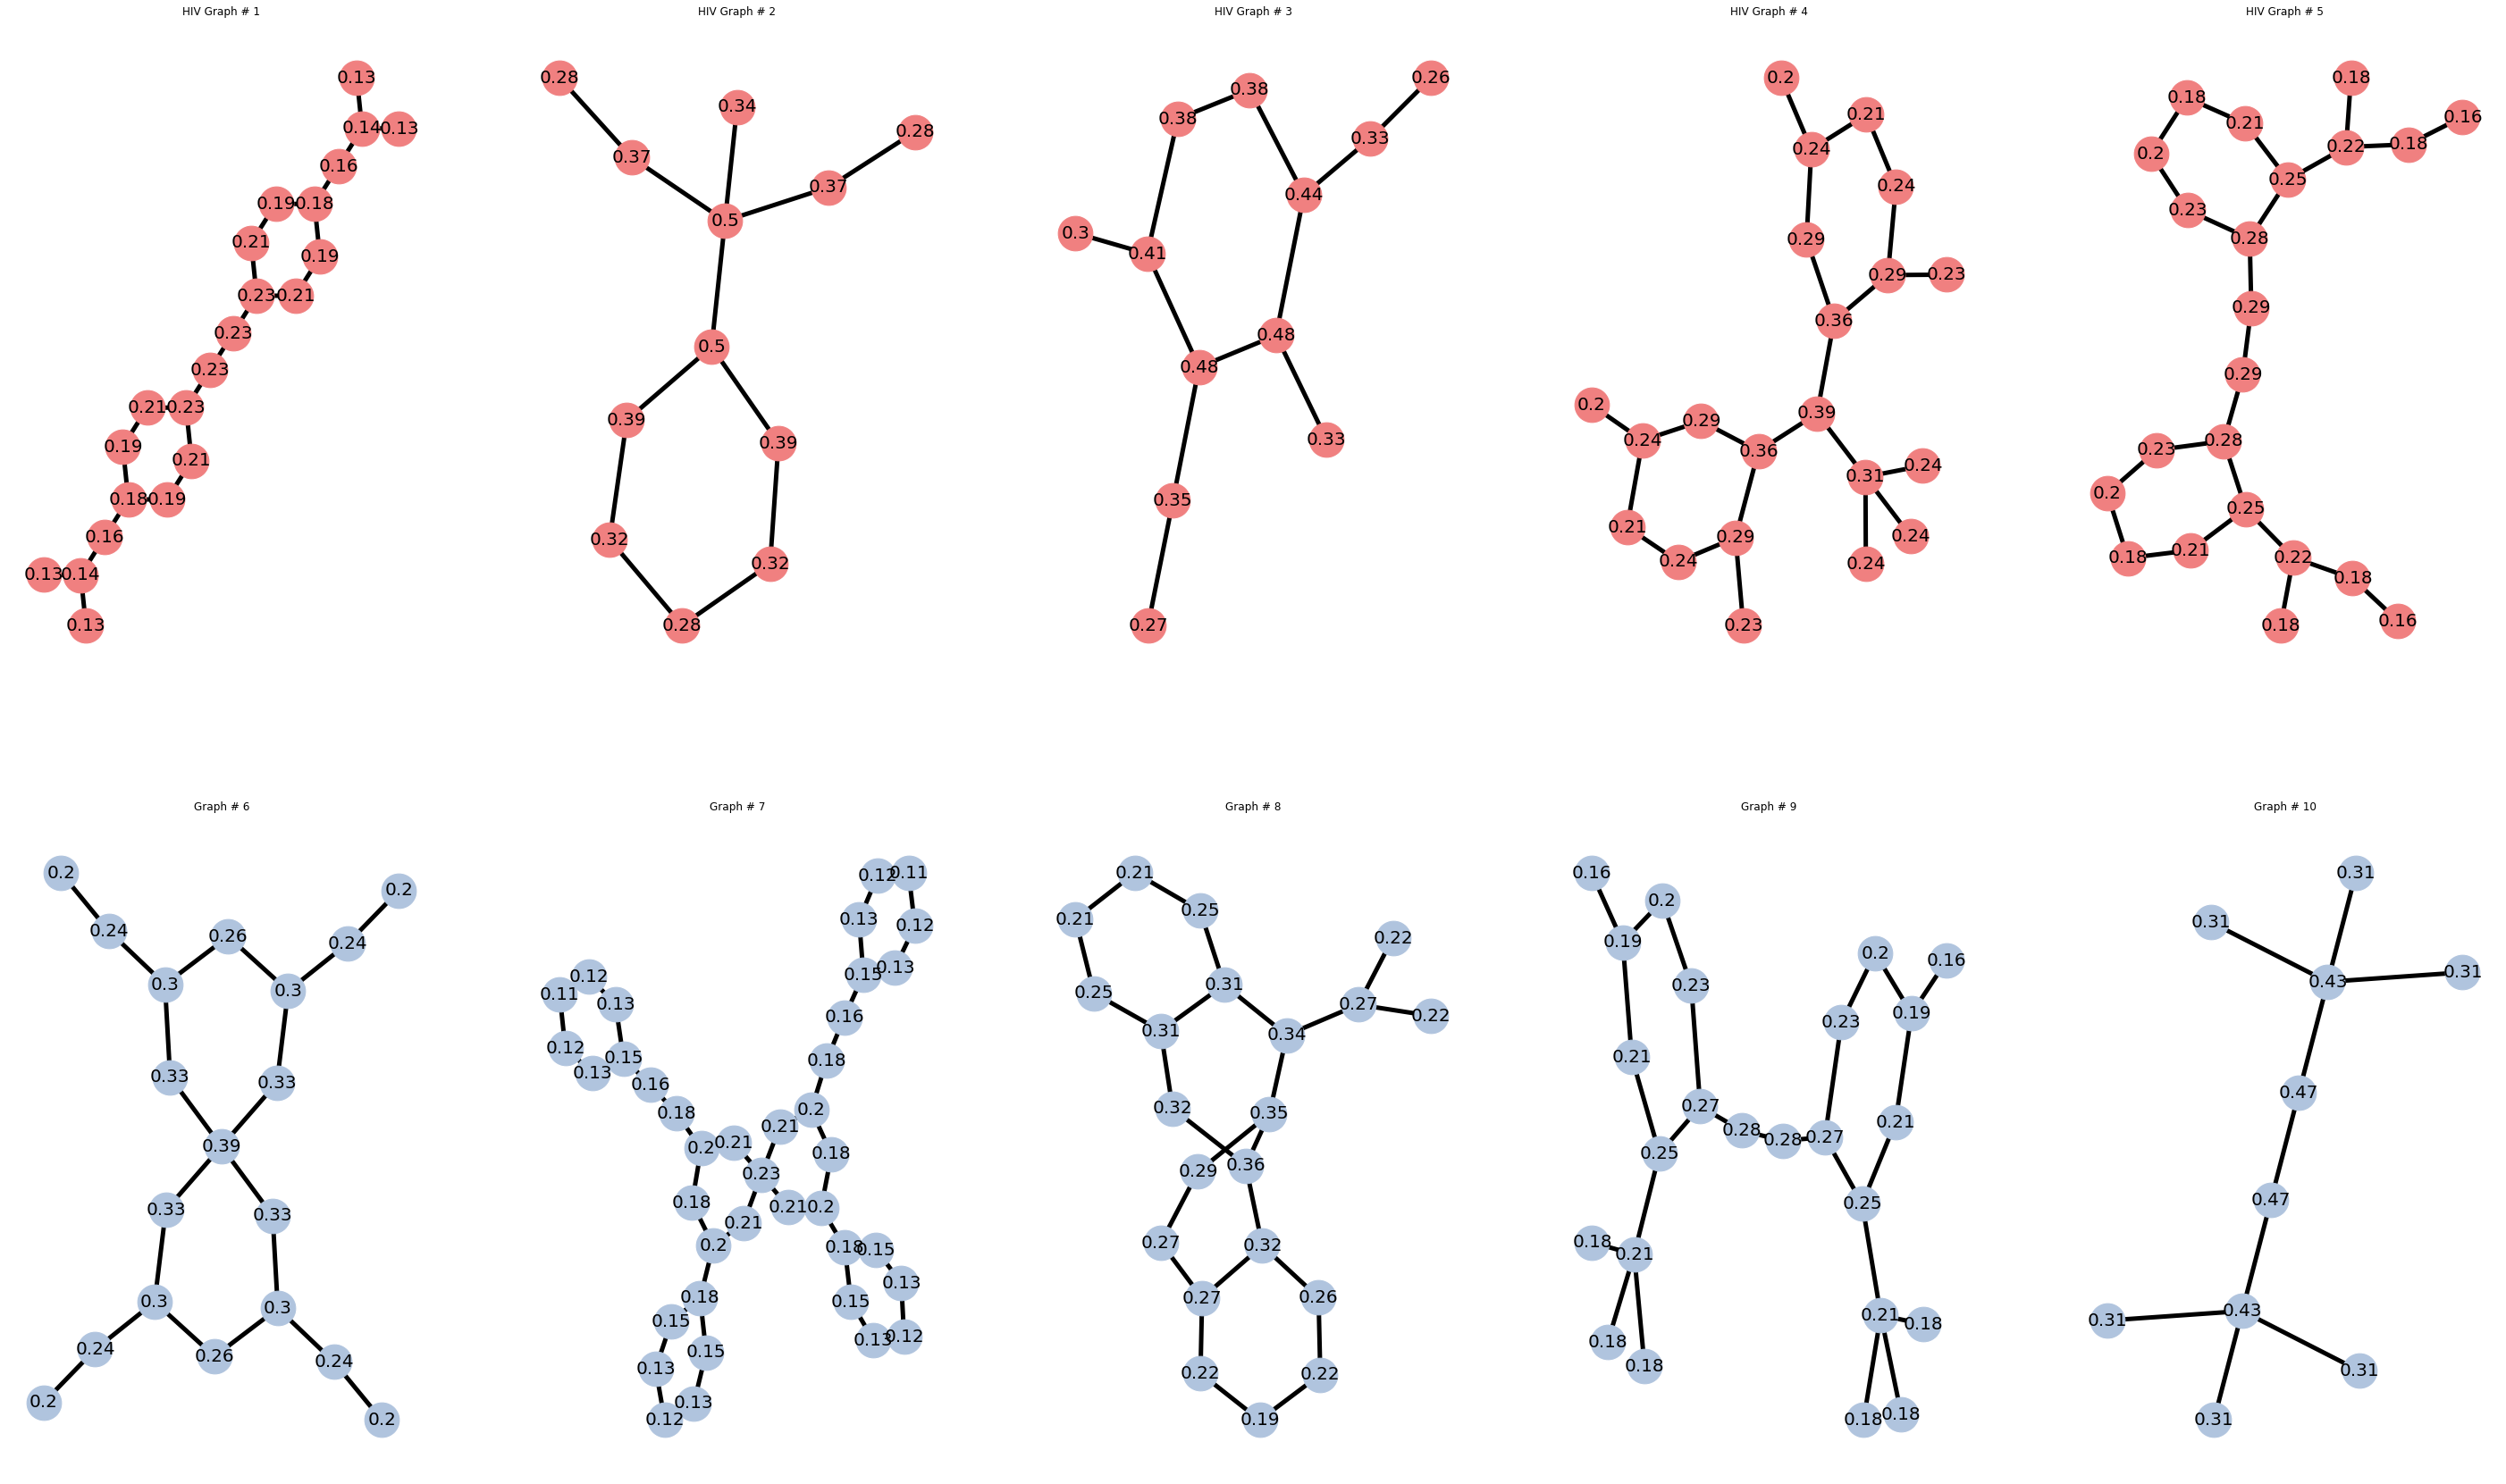

In [197]:
plt.figure(figsize=(50, 30))
for graph_number, networkx_graph in enumerate(
    hiv_positive_graphs + hiv_negative_graphs
):
    if graph_number <= 4:
        plot_networkx_graph(
            networkx_graph,
            graph_number,
            ClCEachGraph(hiv_positive_graphs)[graph_number],
        )
    else:
        plot_networkx_graph(
            networkx_graph,
            graph_number,
            ClCEachGraph(hiv_negative_graphs)[graph_number - 5],
        )
plt.show()

#### Clustering coefficient

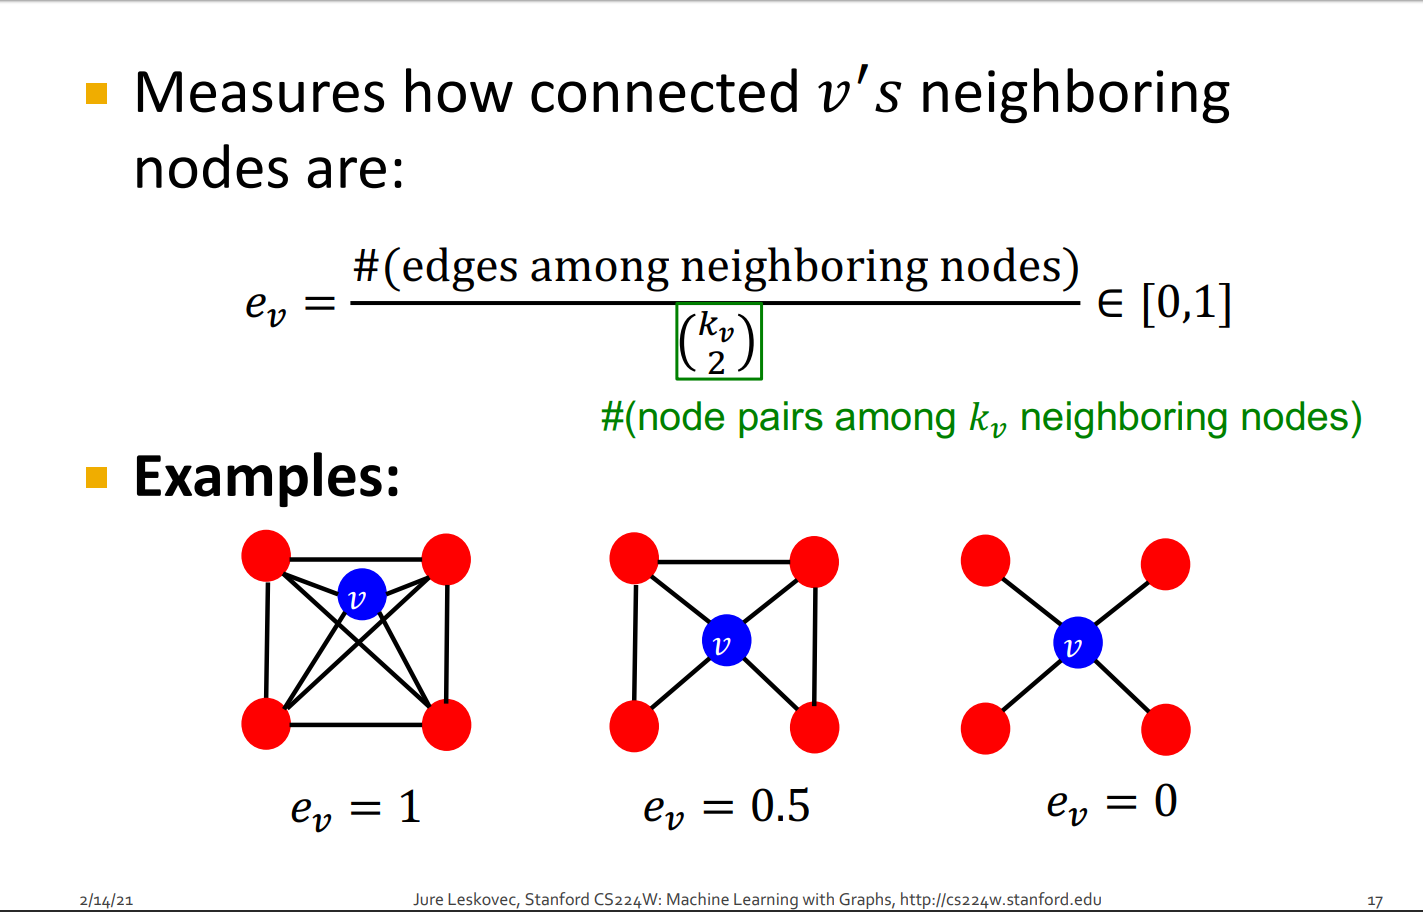

In [198]:
def CCEachGraph(Graphs: list[nx.Graph]) -> list:
    cc_list = []
    for graph in Graphs:
        clustering_coefficient = nx.clustering(graph)
        cc_list.append(
            {key: round(value, 2) for key, value in clustering_coefficient.items()}
        )
    return cc_list

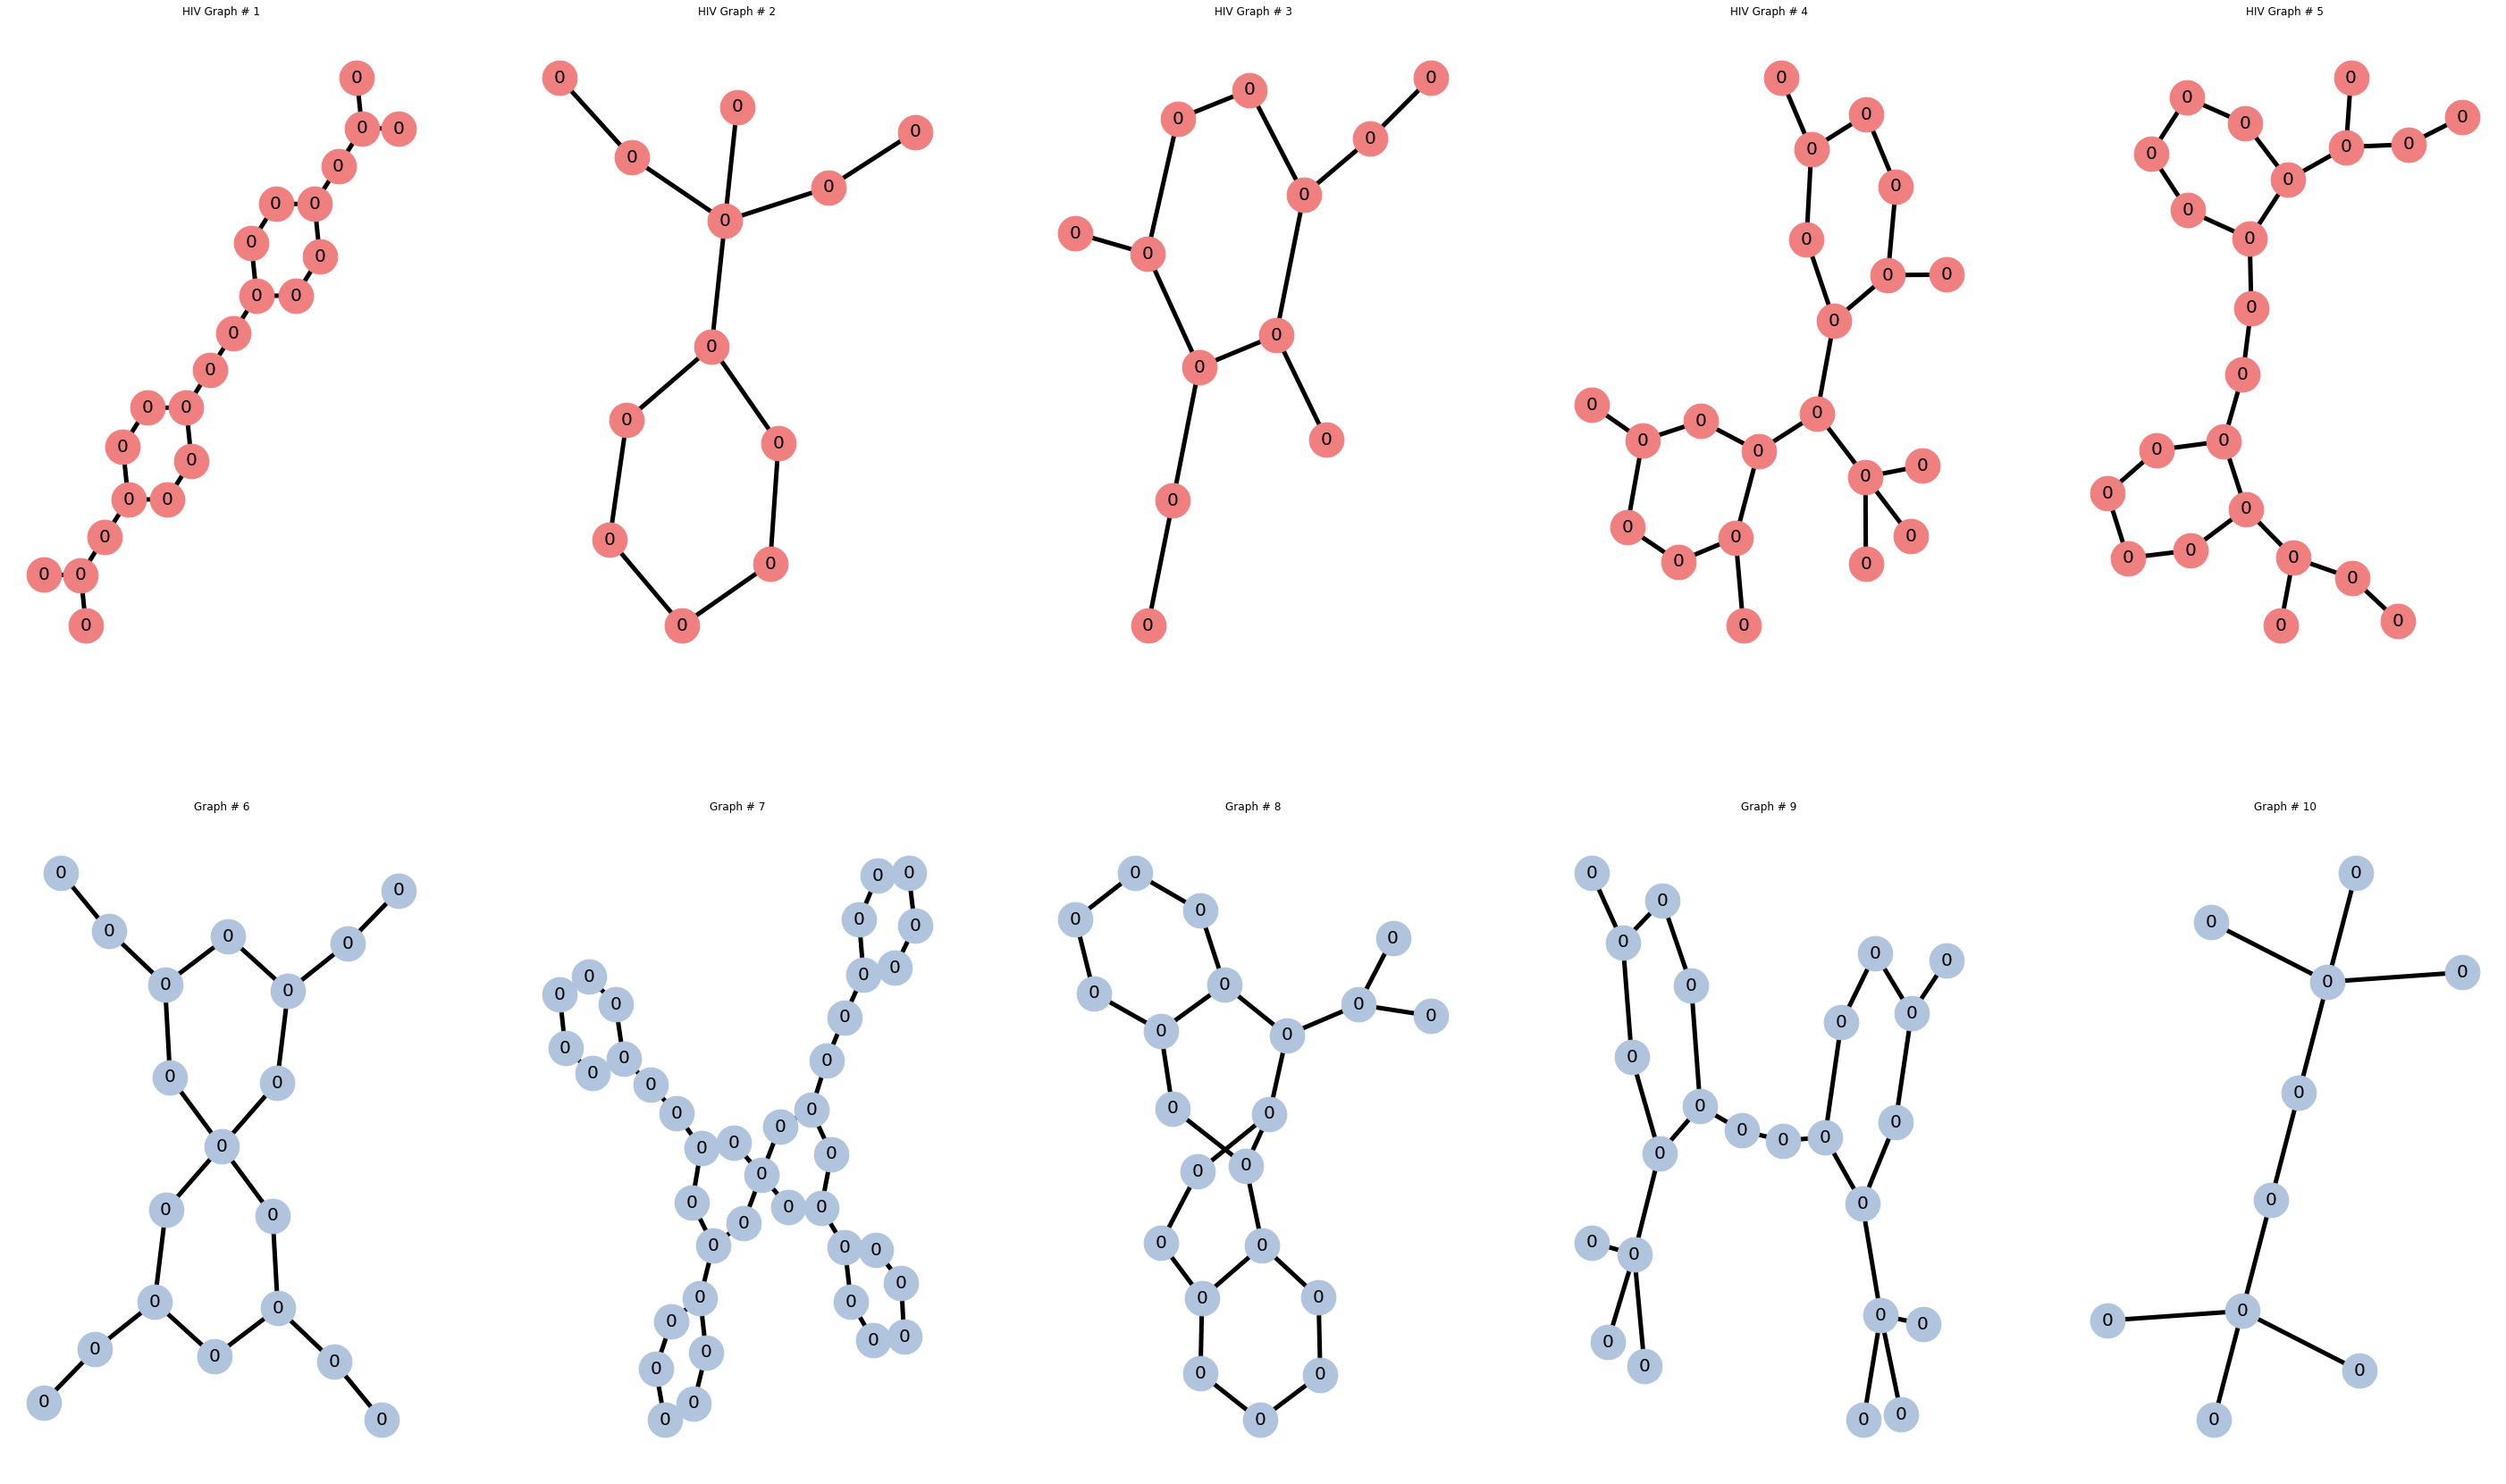

In [199]:
plt.figure(figsize=(50, 30))
for graph_number, networkx_graph in enumerate(
    hiv_positive_graphs + hiv_negative_graphs
):
    if graph_number <= 4:
        plot_networkx_graph(
            networkx_graph, graph_number, CCEachGraph(hiv_positive_graphs)[graph_number]
        )
    else:
        plot_networkx_graph(
            networkx_graph,
            graph_number,
            CCEachGraph(hiv_negative_graphs)[graph_number - 5],
        )
plt.show()

## Extract Link Features

1. Distance-based feaures

In [200]:
def compute_all_shortest_paths(graph: nx.Graph):
    """
    Compute the shortest paths between every pair of nodes in the given NetworkX graph.
    
    Parameters:
    graph (networkx.Graph): Input graph.
    
    Returns:
    dict: A dictionary containing shortest path lengths between all pairs of nodes.
    """
    shortest_paths = dict(nx.all_pairs_shortest_path_length(graph))
    return shortest_paths

In [201]:
def plot_networkx_graph_link_features(
    networkX_graph: nx.Graph, graph_number: int, node_labels: dict = {}
) -> None:
    """Plot one of ten networkx graphs in 2*5 subplot figure
    Parameters
    ----------
    networkX_graph: nx.Graph
        The networkx graph
    graph_number: int
        The index number of graph to be inserted in figure as subplot
    label: dict
    Returns
    ----------
    None
    """
    node_color = "lightsteelblue"
    hiv = ""
    if networkX_graph.graph["y"][0][0] != 0:
        node_color = "lightcoral"
        hiv = "HIV "

    plt.subplot(2, 5, graph_number + 1, frameon=False)
    plt.title(f"{hiv}Graph # {str(graph_number + 1)}")
    plt.axis("off")

    options = {
        "node_color": node_color,
        "node_size": 1500,
        "font_size": 20,
        "width": 5,
        # "edge_alpha": 0.5,
    }

    if node_labels != {}:
        options["labels"] = node_labels


    node_color = "lightsteelblue"
    edge_colors = nx.get_edge_attributes(networkX_graph, 'color').values()
    edge_labels = nx.get_edge_attributes(networkX_graph, 'weight').values()

    # edge_labels = {(u, v): d['weight'] for u, v, d in networkX_graph.edges(data=True) if d['weight'] > 1}

    nx.draw_kamada_kawai(networkX_graph, with_labels=True, edge_color=edge_labels, **options)
    # pos = nx.kamada_kawai_layout(networkX_graph)
    # nx.draw(networkX_graph, pos, with_labels=True, edge_color=edge_colors, **options)
    # nx.draw_networkx_edge_labels(networkX_graph, pos, edge_labels=edge_labels)

    return None

In [202]:
def add_LF_as_new_edge(graph: nx.Graph, shortest_paths: dict, edge_color: str):
    """
    Add some edges to the graph considering the shortest path link feature
    """
    for source_node, paths in shortest_paths.items():
        for target_node, shortest_path_length in paths.items():
            if shortest_path_length < 2:
                continue
            link_weight = shortest_path_length
            graph.add_edge(source_node, target_node, weight=link_weight, color=edge_color)
    return graph

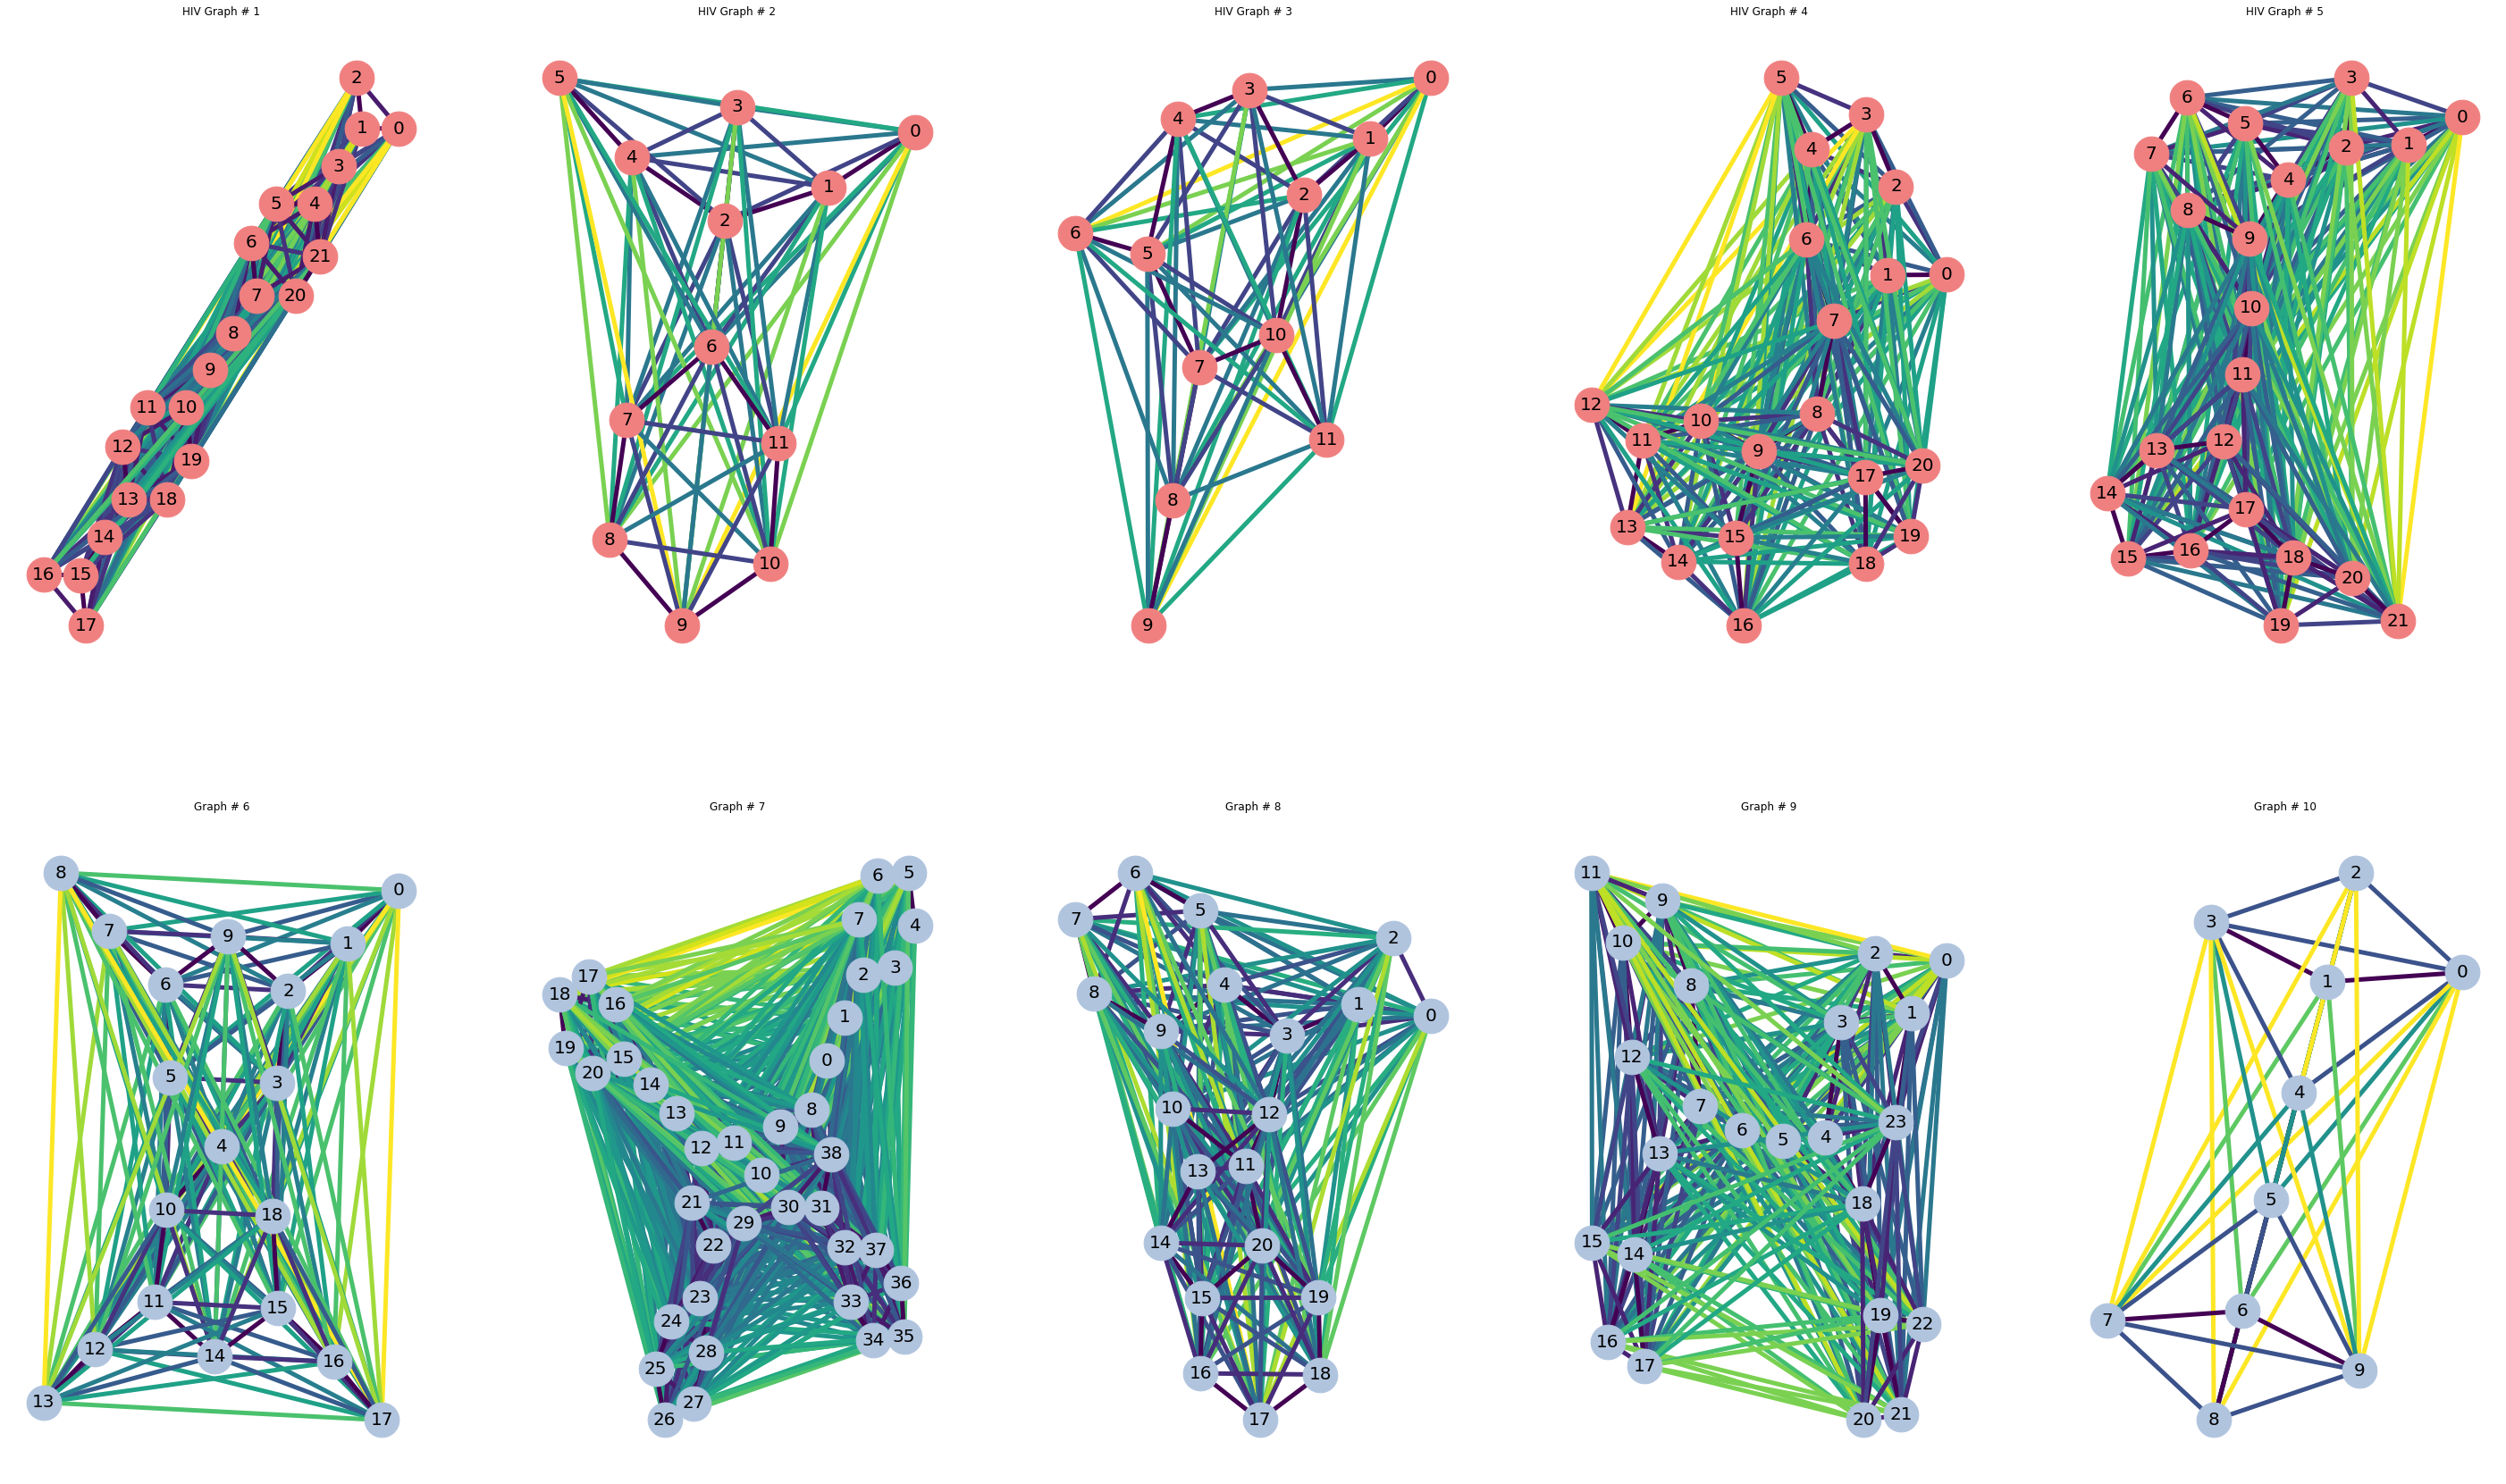

In [203]:
plt.figure(figsize=(50, 30))
for graph_number, networkx_graph in enumerate(
    hiv_positive_graphs + hiv_negative_graphs
):
    # Compute the shortest paths between every pair of nodes
    shortest_paths = compute_all_shortest_paths(networkx_graph)

    # Set blue color for all default graph edges
    edge_color = 'black'

    # Set 'color' attribute for all edges in the graph
    nx.set_edge_attributes(networkx_graph, edge_color, 'color')
    nx.set_edge_attributes(networkx_graph, 1, 'weight')
    new_graph = add_LF_as_new_edge(networkx_graph, shortest_paths, edge_color='red')

    plot_networkx_graph_link_features(
            new_graph, graph_number
        )
plt.show()

2. Common Neighbors

In [208]:
def compute_all_common_neighbors(graph: nx.Graph):
    """
    Compute the shortest paths between every pair of nodes in the given NetworkX graph.
    
    Parameters:
    graph (networkx.Graph): Input graph.
    
    Returns:
    dict: A dictionary containing shortest path lengths between all pairs of nodes.
    """
    
    # Compute common neighbors as edge weights
    for u, v in graph.edges():
        common_neighbors = len(list(nx.common_neighbors(graph, u, v)))
        graph[u][v]['weight'] = common_neighbors

    return graph

In [213]:


for u, v in hiv_negative_graphs[0].edges():
    common_neighbors = len(list(nx.common_neighbors(hiv_negative_graphs[0], u, v)))
    hiv_negative_graphs[0][u][v]['weight'] = common_neighbors

nx.get_edge_attributes(hiv_negative_graphs[0], 'weight').values()



dict_values([17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17])

In [212]:
common_neighbors_feature_graph = compute_all_common_neighbors(hiv_negative_graphs[0])

print(common_neighbors_feature_graph.nodes())
print(common_neighbors_feature_graph.edges())
edge_colors = nx.get_edge_attributes(common_neighbors_feature_graph, 'color').values()
print(edge_colors)
edge_labels = nx.get_edge_attributes(common_neighbors_feature_graph, 'weight').values()
print(edge_labels)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[(0, 1), (0, 2), (0, 3), (0, 9), (0, 4), (0, 6), (0, 5), (0, 7), (0, 10), (0, 18), (0, 8), (0, 11), (0, 15), (0, 12), (0, 14), (0, 16), (0, 17), (0, 13), (1, 2), (1, 3), (1, 9), (1, 4), (1, 6), (1, 5), (1, 7), (1, 10), (1, 18), (1, 8), (1, 11), (1, 15), (1, 12), (1, 14), (1, 16), (1, 17), (1, 13), (2, 3), (2, 9), (2, 4), (2, 6), (2, 5), (2, 7), (2, 10), (2, 18), (2, 8), (2, 11), (2, 15), (2, 12), (2, 14), (2, 16), (2, 17), (2, 13), (3, 4), (3, 5), (3, 9), (3, 10), (3, 18), (3, 6), (3, 11), (3, 15), (3, 7), (3, 12), (3, 14), (3, 16), (3, 8), (3, 13), (3, 17), (4, 5), (4, 10), (4, 18), (4, 6), (4, 11), (4, 15), (4, 7), (4, 9), (4, 12), (4, 14), (4, 16), (4, 8), (4, 13), (4, 17), (5, 6), (5, 7), (5, 9), (5, 10), (5, 18), (5, 8), (5, 11), (5, 15), (5, 12), (5, 14), (5, 16), (5, 13), (5, 17), (6, 7), (6, 9), (6, 8), (6, 10), (6, 18), (6, 11), (6, 15), (6, 12), (6, 14), (6, 16), (6, 17), (6, 13), (7, 8), (7, 9), (7, 10), (7, 

In [ ]:
# plt.figure(figsize=(50, 30))
for graph_number, networkx_graph in enumerate(
    hiv_positive_graphs + hiv_negative_graphs
):
    common_neighbors_feature_graph = compute_all_common_neighbors(networkx_graph)

    # # Set blue color for all default graph edges
    # edge_color = 'black'

    # # Set 'color' attribute for all edges in the graph
    # nx.set_edge_attributes(networkx_graph, edge_color, 'color')
    # nx.set_edge_attributes(networkx_graph, 1, 'weight')
    # new_graph = add_LF_as_new_edge(networkx_graph, shortest_paths, edge_color='red')

    # plot_networkx_graph_link_features(
    #         new_graph, graph_number
    #     )
# plt.show()

In [214]:
import networkx as nx

# Create a graph (replace this with your graph creation logic)
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4])
G.add_edges_from([(1, 2), (1, 3), (2, 4), (3, 4)])

# Compute common neighbors as edge weights
for u, v in G.edges():
    common_neighbors = len(list(nx.common_neighbors(G, u, v)))
    G[u][v]['weight'] = common_neighbors

# Print edge weights
for u, v, data in G.edges(data=True):
    print(f"Edge ({u}, {v}) - Common Neighbors: {data['weight']}")

Edge (1, 2) - Common Neighbors: 0
Edge (1, 3) - Common Neighbors: 0
Edge (2, 4) - Common Neighbors: 0
Edge (3, 4) - Common Neighbors: 0


In [215]:
nx.get_edge_attributes(G, 'weight').values()

dict_values([0, 0, 0, 0])

In [216]:
import networkx as nx

# Create a graph (replace this with your graph creation logic)
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4])
G.add_edges_from([(1, 2), (1, 3), (2, 4), (3, 4)])

# Nodes for which you want to find common neighbors
node_u = 1
node_v = 2

# Compute common neighbors of nodes u and v
common_neighbors = list(nx.common_neighbors(G, node_u, node_v))

# Print the common neighbors
print(f"Common neighbors of nodes {node_u} and {node_v}: {common_neighbors}")


Common neighbors of nodes 1 and 2: []


Common neighbors of nodes 1 and 2: []


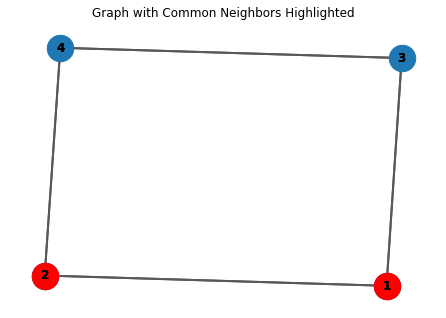

In [217]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph (replace this with your graph creation logic)
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4])
G.add_edges_from([(1, 2), (1, 3), (2, 4), (3, 4)])

# Nodes for which you want to find common neighbors
node_u = 1
node_v = 2

# Compute common neighbors of nodes u and v
common_neighbors = list(nx.common_neighbors(G, node_u, node_v))

# Print the common neighbors
print(f"Common neighbors of nodes {node_u} and {node_v}: {common_neighbors}")

# Plot the graph
pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm
nx.draw(G, pos, with_labels=True, node_size=700, font_size=12, font_weight='bold', width=2)

# Highlight nodes u and v and their common neighbors
highlight_nodes = [node_u, node_v] + common_neighbors
node_colors = ['red' if node in highlight_nodes else 'skyblue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_color='red', node_size=700)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
nx.draw_networkx_edges(G, pos, width=2, edge_color='gray', alpha=0.7)

plt.title("Graph with Common Neighbors Highlighted")
plt.show()
